<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/PCCandidateModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 18.4 MB/s eta 0:00:00


# LSTM

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, balanced_accuracy_score,
                             precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
from sksurv.metrics import concordance_index_censored
import warnings

# Reproducibility
import random
random.seed(365)
np.random.seed(365)
tf.random.set_seed(365)
warnings.filterwarnings('ignore')

# --- AUTOENCODER IMPUTER ---
class TemporalAutoencoder:
    def __init__(self, sequence_length, feature_dim):
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.model = self._build_ae()

    def _build_ae(self):
        inputs = layers.Input(shape=(self.sequence_length, self.feature_dim))
        # Encoder
        encoded = layers.LSTM(32, activation='relu', return_sequences=False)(inputs)
        # Decoder
        decoded = layers.RepeatVector(self.sequence_length)(encoded)
        decoded = layers.LSTM(32, activation='relu', return_sequences=True)(decoded)
        outputs = layers.TimeDistributed(layers.Dense(self.feature_dim))(decoded)

        ae = models.Model(inputs, outputs)
        ae.compile(optimizer='adam', loss='mse')
        return ae

    def train(self, X):
        early_stop = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        self.model.fit(X, X, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

    def impute(self, X):
        reconstructed = self.model.predict(X, verbose=0)
        # Replace only the missing (zero) values with reconstructed values
        mask = (X == 0).astype(float)
        return X + (mask * reconstructed)

# --- MAIN SURVIVAL PIPELINE ---
class DeepSurvivalLSTM:
    def __init__(self, n_splits=3, sequence_length=12):
        self.n_splits = n_splits
        self.sequence_length = sequence_length
        self.feature_cols = [
            'ECOGGRN', 'current_age', 'BMI', 'SYSBP', 'PULSE',
            'cycle_number', 'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced', 'ongoing_ae_count'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()
        self.ae_imputer = TemporalAutoencoder(sequence_length, self.input_dim)

    def prepare_data(self, df):
        pid_col = 'RPT' if 'RPT' in df.columns else 'SUBJID'
        X_list, y_status, y_time = [], [], []

        df_scaled = df.copy()
        # Zero-fill for initial scaling and AE processing
        df_scaled[self.feature_cols] = df_scaled[self.feature_cols].fillna(0)
        df_scaled[self.feature_cols] = self.scaler.fit_transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')
            feat_seq = p_data[self.feature_cols].values[-self.sequence_length:]

            if len(feat_seq) < self.sequence_length:
                pad_width = self.sequence_length - len(feat_seq)
                feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant', constant_values=0)

            X_list.append(feat_seq)
            y_status.append(int(p_data['os_event'].any()))
            y_time.append(p_data['VISDAY'].max())

        X = np.array(X_list)

        # Train Autoencoder on the sequence data and impute
        self.ae_imputer.train(X)
        X_imputed = self.ae_imputer.impute(X)

        return X_imputed, np.array(y_status), np.array(y_time)

    def build_model(self):
        model = models.Sequential([
            layers.Input(shape=(self.sequence_length, self.input_dim)),
            # Masking removed because AE provides continuous data
            layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
            layers.BatchNormalization(),
            layers.LSTM(32, dropout=0.2),
            layers.BatchNormalization(),
            layers.Dense(32, activation='relu', kernel_regularizer='l2'),
            layers.Dropout(0.4),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )
        return model

    def run(self, df):
        X, y_status, y_time = self.prepare_data(df)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=365)

        all_probs, all_true_status, fold_cindex = [], [], []

        print(f"Training model...")

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_status), 1):
            X_tr, X_te = X[train_idx], X[test_idx]
            ys_tr, ys_te = y_status[train_idx], y_status[test_idx]
            yt_te = y_time[test_idx]

            neg, pos = np.bincount(ys_tr)
            cw = {0: (1/neg)*(len(ys_tr)/2.0), 1: (1/pos)*(len(ys_tr)/2.0)}

            sm = SMOTE(random_state=42)
            X_tr_flat = X_tr.reshape(X_tr.shape[0], -1)
            X_tr_res, ys_tr_res = sm.fit_resample(X_tr_flat, ys_tr)
            X_tr_res = X_tr_res.reshape(-1, self.sequence_length, self.input_dim)

            model = self.build_model()
            early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
            reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

            model.fit(
                X_tr_res, ys_tr_res,
                epochs=40,
                batch_size=16,
                validation_split=0.15,
                class_weight=cw,
                callbacks=[early_stop, reduce_lr],
                verbose=0
            )

            probs = model.predict(X_te, verbose=0).flatten()
            c_idx = concordance_index_censored(ys_te.astype(bool), yt_te, probs)[0]
            fold_cindex.append(c_idx)

            all_probs.extend(probs)
            all_true_status.extend(ys_te)

        all_probs = np.array(all_probs)
        all_true_status = np.array(all_true_status)

        # --- TARGETED SENSITIVITY LOGIC ---
        thresholds = np.linspace(0.01, 0.99, 200)
        target_sensitivity = 0.90

        best_t = 0.5 # fallback
        max_spec = -1

        for t in thresholds:
            preds = (all_probs >= t).astype(int)
            sens = recall_score(all_true_status, preds)

            # If we meet the 90% sensitivity requirement
            if sens >= target_sensitivity:
                tn, fp, fn, tp = confusion_matrix(all_true_status, preds).ravel()
                spec = tn / (tn + fp)
                # Maximize specificity while keeping sensitivity >= 90%
                if spec > max_spec:
                    max_spec = spec
                    best_t = t

        final_preds = (all_probs >= best_t).astype(int)
        self.display_results(fold_cindex, all_true_status, final_preds, best_t)

    def display_results(self, c_indices, y_true, y_pred, t):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = recall_score(y_true, y_pred)
        spec = tn / (tn + fp)
        ba = (sens + spec) / 2
        ppv = precision_score(y_true, y_pred)
        npv = tn / (tn + fn)

        print("\n" + "="*60)
        print(f"FINAL PERFORMANCE (TARGET SENSITIVITY: 90%)")
        print("="*60)
        print(f"Mean C-Index (Harrell's) : {np.mean(c_indices):.4f} ± {np.std(c_indices):.4f}")
        print(f"Sensitivity (Recall)     : {sens:.4f}  <-- Target")
        print(f"Specificity              : {spec:.4f}  <-- Maximized")
        print(f"Balanced Accuracy        : {ba:.4f}")
        print(f"PPV (Precision)          : {ppv:.4f}")
        print(f"NPV                      : {npv:.4f}")
        print(f"Targeted Risk Threshold  : {t:.4f}")
        print("-" * 60)
        print(f"Confusion Matrix: [TN: {tn}, FP: {fp}]")
        print(f"                  [FN: {fn}, TP: {tp}]")
        print("="*60)

# Execution
pcdata = pd.read_csv('pcdata.csv')
#pcdata = pd.read_csv('pcvaldata.csv')
lstm_pipeline = DeepSurvivalLSTM()
lstm_pipeline.run(pcdata)


Training model...


ValueError: Input event_time contains NaN.

Training across 3 folds...


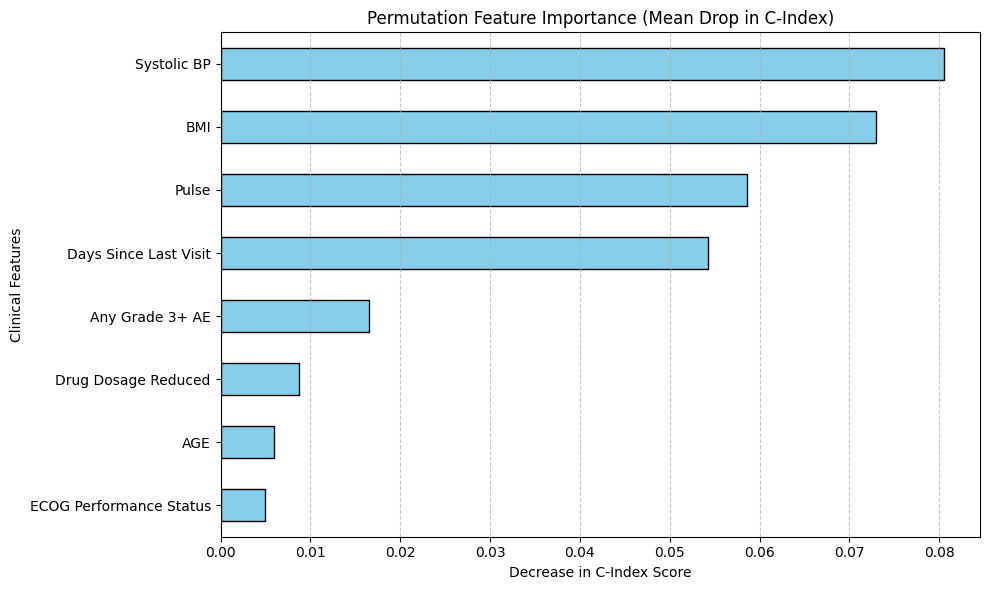


FINAL PERFORMANCE (TARGET SENSITIVITY: 90%) - 95% Confidence Intervals
Mean C-Index             : 0.7767 ± 0.0195
Sensitivity (Recall)     : 0.9079 [0.836 - 0.968]
Specificity              : 0.5622 [0.513 - 0.608]
Balanced Accuracy        : 0.7351 [0.693 - 0.774]
PPV (Precision)          : 0.2594 [0.207 - 0.311]
NPV                      : 0.9731 [0.951 - 0.991]
Targeted Risk Threshold  : 0.5544
----------------------------------------------------------------------
Confusion Matrix: [TN: 253, FP: 197] | [FN: 7, TP: 69]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, balanced_accuracy_score,
                             precision_score, recall_score, f1_score)
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sksurv.metrics import concordance_index_censored
import warnings

# Reproducibility
import random
random.seed(365)
np.random.seed(365)
tf.random.set_seed(365)
warnings.filterwarnings('ignore')

# --- AUTOENCODER IMPUTER ---
class TemporalAutoencoder:
    def __init__(self, sequence_length, feature_dim):
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.model = self._build_ae()

    def _build_ae(self):
        inputs = layers.Input(shape=(self.sequence_length, self.feature_dim))
        encoded = layers.LSTM(32, activation='relu', return_sequences=False)(inputs)
        decoded = layers.RepeatVector(self.sequence_length)(encoded)
        decoded = layers.LSTM(32, activation='relu', return_sequences=True)(decoded)
        outputs = layers.TimeDistributed(layers.Dense(self.feature_dim))(decoded)
        ae = models.Model(inputs, outputs)
        ae.compile(optimizer='adam', loss='mse')
        return ae

    def train(self, X):
        early_stop = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        self.model.fit(X, X, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

    def impute(self, X):
        reconstructed = self.model.predict(X, verbose=0)
        mask = (X == 0).astype(float)
        return X + (mask * reconstructed)

# --- MAIN SURVIVAL PIPELINE ---
class DeepSurvivalLSTM:
    def __init__(self, n_splits=3, sequence_length=15):
        self.n_splits = n_splits
        self.sequence_length = sequence_length
        self.feature_cols = [
            'ECOGGRN', 'AGE', 'BMI', 'SYSBP', 'PULSE',
            'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()
        self.ae_imputer = TemporalAutoencoder(sequence_length, self.input_dim)

    def prepare_data(self, df):
        pid_col = 'RPT' if 'RPT' in df.columns else 'patient_id'
        X_list, y_status, y_time = [], [], []

        df_scaled = df.copy()
        df_scaled[self.feature_cols] = df_scaled[self.feature_cols].fillna(0)
        df_scaled[self.feature_cols] = self.scaler.fit_transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')
            feat_seq = p_data[self.feature_cols].values[-self.sequence_length:]

            if len(feat_seq) < self.sequence_length:
                pad_width = self.sequence_length - len(feat_seq)
                feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant', constant_values=0)

            X_list.append(feat_seq)
            y_status.append(int(p_data['os_event'].any()))
            y_time.append(p_data['VISDAY'].max())

        X = np.array(X_list)
        self.ae_imputer.train(X)
        X_imputed = self.ae_imputer.impute(X)
        return X_imputed, np.array(y_status), np.array(y_time)

    def build_model(self):
        model = models.Sequential([
            layers.Input(shape=(self.sequence_length, self.input_dim)),
            layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
            layers.BatchNormalization(),
            layers.LSTM(32, dropout=0.2),
            layers.BatchNormalization(),
            layers.Dense(32, activation='relu', kernel_regularizer='l2'),
            layers.Dropout(0.4),
            layers.Dense(1, activation='sigmoid')
        ])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return model

    def calculate_metrics(self, y_true, y_probs, threshold):
        """Helper to calculate multiple metrics at once."""
        y_pred = (y_probs >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        sens = recall_score(y_true, y_pred)
        spec = tn / (tn + fp)
        ppv = precision_score(y_true, y_pred, zero_division=0)
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        ba = (sens + spec) / 2

        return {"sens": sens, "spec": spec, "ppv": ppv, "npv": npv, "ba": ba}

    def bootstrap_intervals(self, y_true, y_probs, threshold, n_iterations=1000):
        """Generates 95% Confidence Intervals using bootstrapping."""
        stats = {k: [] for k in ["sens", "spec", "ppv", "npv", "ba"]}

        for i in range(n_iterations):
            # Sample indices with replacement
            indices = resample(np.arange(len(y_true)), replace=True)
            if len(np.unique(y_true[indices])) < 2:
                continue # Skip iterations that don't have both classes

            resampled_metrics = self.calculate_metrics(y_true[indices], y_probs[indices], threshold)
            for k, v in resampled_metrics.items():
                stats[k].append(v)

        # Calculate percentiles for 95% CI
        intervals = {}
        for k, v in stats.items():
            intervals[k] = (np.percentile(v, 2.5), np.percentile(v, 97.5))
        return intervals

    def run(self, df):
        X, y_status, y_time = self.prepare_data(df)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=365)

        all_probs, all_true_status, fold_cindex = [], [], []
        fold_importances = [] # Track importance per fold
        print(f"Training across {self.n_splits} folds...")

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_status), 1):
            X_tr, X_te = X[train_idx], X[test_idx]
            ys_tr, ys_te = y_status[train_idx], y_status[test_idx]
            yt_te = y_time[test_idx]

            neg, pos = np.bincount(ys_tr)
            cw = {0: (1/neg)*(len(ys_tr)/2.0), 1: (1/pos)*(len(ys_tr)/2.0)}

            sm = SMOTE(random_state=42)
            X_tr_flat = X_tr.reshape(X_tr.shape[0], -1)
            X_tr_res, ys_tr_res = sm.fit_resample(X_tr_flat, ys_tr)
            X_tr_res = X_tr_res.reshape(-1, self.sequence_length, self.input_dim)

            model = self.build_model()
            early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
            model.fit(
                X_tr_res, ys_tr_res,
                epochs=40, batch_size=16,
                validation_split=0.15, class_weight=cw,
                callbacks=[early_stop], verbose=0
            )
            # 1. Calculate Importance for this fold
            imp = self.calculate_permutation_importance(model, X_te, ys_te, yt_te)
            fold_importances.append(imp)

            # 2. Existing predictions
            probs = model.predict(X_te, verbose=0).flatten()
            c_idx = concordance_index_censored(ys_te.astype(bool), yt_te, probs)[0]
            fold_cindex.append(c_idx)
            all_probs.extend(probs)
            all_true_status.extend(ys_te)

        mean_importances = np.mean(fold_importances, axis=0)
        self.plot_importance(mean_importances)

        all_probs = np.array(all_probs)
        all_true_status = np.array(all_true_status)

        # Find best threshold for 90% sensitivity
        thresholds = np.linspace(0.01, 0.99, 100)
        best_t, max_spec = 0.5, -1

        for t in thresholds:
            preds = (all_probs >= t).astype(int)
            sens = recall_score(all_true_status, preds)
            if sens >= 0.90:
                tn, fp, fn, tp = confusion_matrix(all_true_status, preds).ravel()
                spec = tn / (tn + fp)
                if spec > max_spec:
                    max_spec, best_t = spec, t

        # Calculate CIs for all metrics
        cis = self.bootstrap_intervals(all_true_status, all_probs, best_t)
        self.display_results(fold_cindex, all_true_status, all_probs, best_t, cis)

    def display_results(self, c_indices, y_true, y_probs, t, cis):
        y_pred = (y_probs >= t).astype(int)
        metrics = self.calculate_metrics(y_true, y_probs, t)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        print("\n" + "="*70)
        print(f"FINAL PERFORMANCE (TARGET SENSITIVITY: 90%) - 95% Confidence Intervals")
        print("="*70)
        print(f"Mean C-Index             : {np.mean(c_indices):.4f} ± {np.std(c_indices):.4f}")
        print(f"Sensitivity (Recall)     : {metrics['sens']:.4f} [{cis['sens'][0]:.3f} - {cis['sens'][1]:.3f}]")
        print(f"Specificity              : {metrics['spec']:.4f} [{cis['spec'][0]:.3f} - {cis['spec'][1]:.3f}]")
        print(f"Balanced Accuracy        : {metrics['ba']:.4f} [{cis['ba'][0]:.3f} - {cis['ba'][1]:.3f}]")
        print(f"PPV (Precision)          : {metrics['ppv']:.4f} [{cis['ppv'][0]:.3f} - {cis['ppv'][1]:.3f}]")
        print(f"NPV                      : {metrics['npv']:.4f} [{cis['npv'][0]:.3f} - {cis['npv'][1]:.3f}]")
        print(f"Targeted Risk Threshold  : {t:.4f}")
        print("-" * 70)
        print(f"Confusion Matrix: [TN: {tn}, FP: {fp}] | [FN: {fn}, TP: {tp}]")
        print("="*70)

    def calculate_permutation_importance(self, model, X_te, ys_te, yt_te):
        """Calculates permutation importance for LSTM features."""
        # Base C-index for reference
        base_probs = model.predict(X_te, verbose=0).flatten()
        base_cindex = concordance_index_censored(ys_te.astype(bool), yt_te, base_probs)[0]

        importances = []

        for i, col in enumerate(self.feature_cols):
            X_permuted = X_te.copy()
            # Shuffle the specific feature across all samples but keep temporal structure
            # We shuffle the feature values for the i-th column
            permutation = np.random.permutation(X_permuted.shape[0])
            X_permuted[:, :, i] = X_permuted[permutation, :, i]

            # Predict with permuted feature
            perm_probs = model.predict(X_permuted, verbose=0).flatten()
            perm_cindex = concordance_index_censored(ys_te.astype(bool), yt_te, perm_probs)[0]

            # Importance is the drop in C-index
            importances.append(base_cindex - perm_cindex)

        return np.array(importances)

    def plot_importance(self, importance_means):
        """Visualizes the feature importances with cleaned labels."""
        # Mapping technical names to display names
        label_mapping = {
            'days_since_last_visit': 'Days Since Last Visit',
            'SYSBP': 'Systolic BP',
            'PULSE': 'Pulse',
            'drug_reduced': 'Drug Dosage Reduced',
            'BMI': 'BMI',
            'any_grade3_plus': 'Any Grade 3+ AE',
            'ECOGGRN': 'ECOG Performance Status',
            'current_age': 'Current Age'
        }

        # Create display names list based on the order of self.feature_cols
        display_names = [label_mapping.get(col, col) for col in self.feature_cols]

        plt.figure(figsize=(10, 6))
        # Use display_names as the index for the series
        feat_imp = pd.Series(importance_means, index=display_names).sort_values(ascending=True)

        feat_imp.plot(kind='barh', color='skyblue', edgecolor='black')
        plt.title('Permutation Feature Importance (Mean Drop in C-Index)')
        plt.xlabel('Decrease in C-Index Score')
        plt.ylabel('Clinical Features')
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
# Execution
pcdata = pd.read_csv('pcdata.csv')
lstm_pipeline = DeepSurvivalLSTM()
lstm_pipeline.run(pcdata)

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


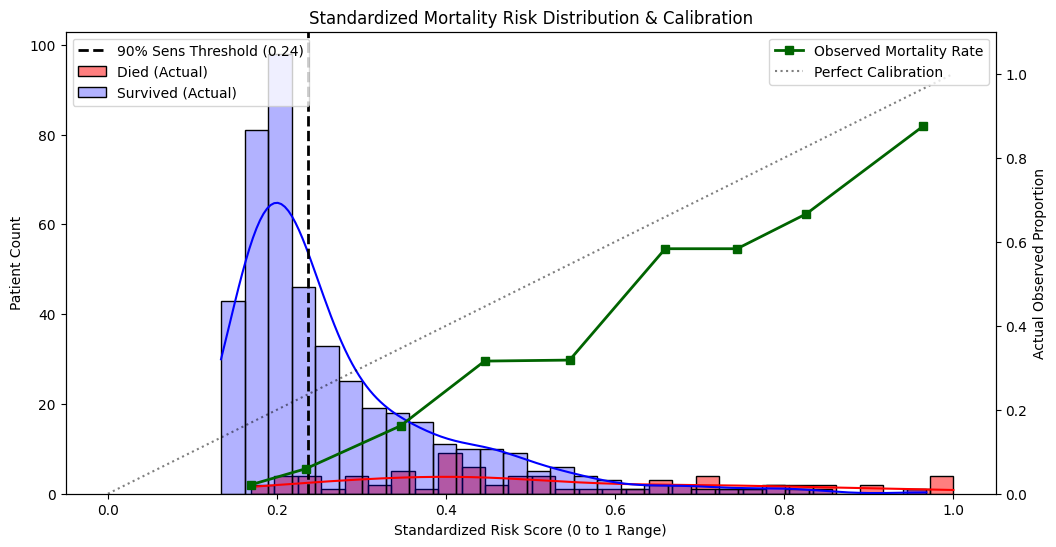

Optimized Standardized Threshold: 0.2362
Calibration Slope (Ideal=1.0): 1.0684
Calibration Intercept (Ideal=0.0): -0.1875
Confusion Matrix:
[[252 198]
 [  7  69]]


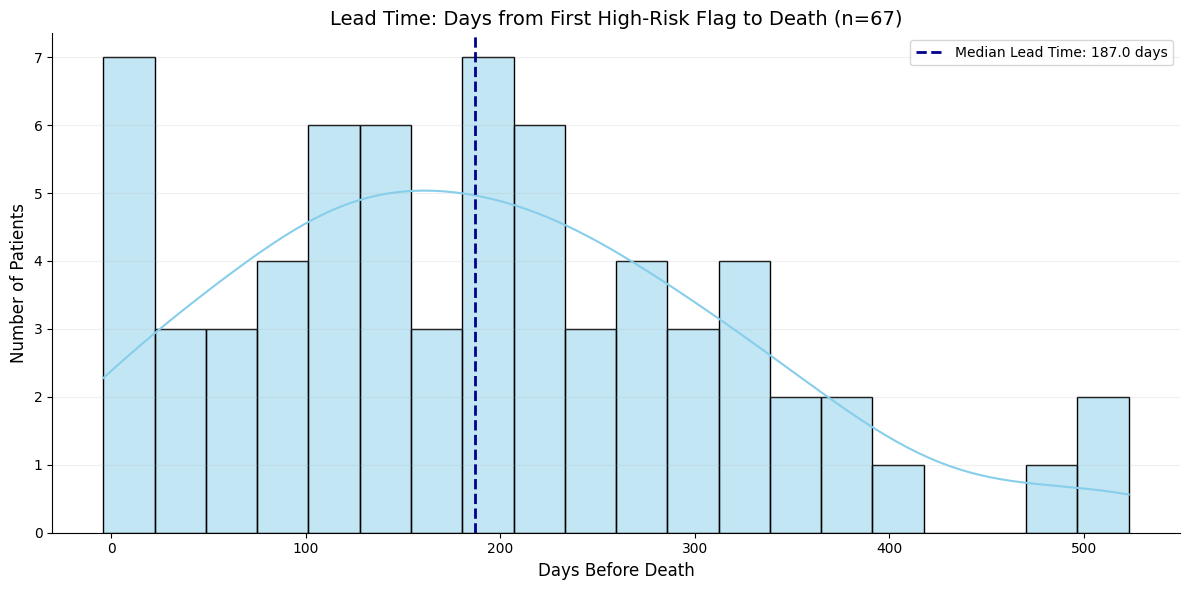

Analysis for Correctly Flagged High-Risk Patients (n=67):
Median Lead Time: 187.00 days
Mean Lead Time: 191.94 days
IQR (Interquartile Range): 175.00 days (100.00 - 275.00)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.calibration import calibration_curve

import random
random.seed(240)
np.random.seed(240)
tf.random.set_seed(240)

class SequentialSurvivalLSTM:
    def __init__(self, sequence_length=12):
        self.sequence_length = sequence_length
        self.feature_cols = [
            'ECOGGRN', 'AGE', 'BMI', 'SYSBP', 'PULSE',
            'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()
        self.min_max_scaler = MinMaxScaler(feature_range=(0, 1))

    def prepare_data(self, df):
        pid_col = 'RPT'
        X_list, y_status, metadata = [], [], []

        df_scaled = df.copy()
        df_scaled[self.feature_cols] = df_scaled[self.feature_cols].fillna(0)
        df_scaled[self.feature_cols] = self.scaler.fit_transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')

            vdays = p_data['VISDAY'].values[-self.sequence_length:]
            dsday = p_data['DSDAY'].iloc[0] if 'DSDAY' in p_data.columns else np.nan

            feat_seq = p_data[self.feature_cols].values[-self.sequence_length:]

            if len(feat_seq) < self.sequence_length:
                pad_width = self.sequence_length - len(feat_seq)
                feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant')
                vdays = np.pad(vdays.astype(float), (pad_width, 0), mode='constant', constant_values=np.nan)

            X_list.append(feat_seq)
            y_status.append(int(p_data['os_event'].any()))
            metadata.append({'pid': pid, 'vdays': vdays, 'dsday': dsday})

        return np.array(X_list), np.array(y_status), metadata

    def build_sequential_model(self):
        inputs = layers.Input(shape=(self.sequence_length, self.input_dim))
        x = layers.LSTM(64, return_sequences=True, dropout=0.3)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LSTM(32, return_sequences=True, dropout=0.2)(x)
        outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)

        model = models.Model(inputs, outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy')
        return model

    def run_analysis(self, df):
        X, y_true, metadata = self.prepare_data(df)

        model = self.build_sequential_model()
        y_seq = np.repeat(y_true[:, np.newaxis, np.newaxis], self.sequence_length, axis=1)

        model.fit(X, y_seq, epochs=30, batch_size=16, verbose=0)

        raw_visit_risks = model.predict(X)

        flattened_risks = raw_visit_risks.reshape(-1, 1)
        standardized_risks = self.min_max_scaler.fit_transform(flattened_risks)
        all_visit_risks = standardized_risks.reshape(raw_visit_risks.shape)

        max_risks = np.max(all_visit_risks, axis=1).flatten()

        thresholds = np.linspace(0, 1, 200)
        best_t = 0.5
        for t in thresholds:
            preds = (max_risks >= t).astype(int)
            if recall_score(y_true, preds) >= 0.90:
                best_t = t
            else:
                break

        self.plot_combined_analysis(max_risks, y_true, best_t)
        self.plot_lead_time_histogram(all_visit_risks, y_true, metadata, best_t)

    def plot_combined_analysis(self, max_risks, y_true, threshold):
        fig, ax1 = plt.subplots(figsize=(12, 6))

        sns.histplot(max_risks[y_true == 1], color='red', label='Died (Actual)',
                     kde=True, bins=30, alpha=0.5, ax=ax1)
        sns.histplot(max_risks[y_true == 0], color='blue', label='Survived (Actual)',
                     kde=True, bins=30, alpha=0.3, ax=ax1)

        ax1.axvline(threshold, color='black', linestyle='--', linewidth=2,
                    label=f'90% Sens Threshold ({threshold:.2f})')
        ax1.set_xlabel('Standardized Risk Score (0 to 1 Range)')
        ax1.set_ylabel('Patient Count')
        ax1.set_title('Standardized Mortality Risk Distribution & Calibration')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        prob_true, prob_pred = calibration_curve(y_true, max_risks, n_bins=10)
        ax2.plot(prob_pred, prob_true, "s-", color='darkgreen', linewidth=2, label='Observed Mortality Rate')
        ax2.plot([0, 1], [0, 1], "k:", alpha=0.5, label='Perfect Calibration')
        ax2.set_ylabel('Actual Observed Proportion')
        ax2.set_ylim(0, 1.1)
        ax2.legend(loc='upper right')
        plt.show()

        # Calculation for Line of Best Fit (Calibration Slope/Intercept)
        slope, intercept = np.polyfit(prob_pred, prob_true, 1)

        # Metrics Summary
        flagged = (max_risks >= threshold).astype(int)
        print(f"Optimized Standardized Threshold: {threshold:.4f}")
        print(f"Calibration Slope (Ideal=1.0): {slope:.4f}")
        print(f"Calibration Intercept (Ideal=0.0): {intercept:.4f}")
        print(f"Confusion Matrix:\n{confusion_matrix(y_true, flagged)}")

    def plot_lead_time_histogram(self, all_visit_risks, y_true, metadata, threshold):
        lead_times = []

        for i in range(len(y_true)):
            if y_true[i] == 1 and np.max(all_visit_risks[i]) >= threshold:
                patient_risks = all_visit_risks[i].flatten()
                flag_indices = np.where(patient_risks >= threshold)[0]

                if len(flag_indices) > 0:
                    first_flag_idx = flag_indices[0]
                    first_flag_day = metadata[i]['vdays'][first_flag_idx]
                    death_day = metadata[i]['dsday']

                    if not np.isnan(first_flag_day) and not np.isnan(death_day):
                        days_before = death_day - first_flag_day
                        lead_times.append(days_before)

        plt.figure(figsize=(12, 6))
        sns.histplot(lead_times, bins=20, kde=True, color='skyblue', edgecolor='black')

        median_val = np.median(lead_times)
        q1 = np.percentile(lead_times, 25)
        q3 = np.percentile(lead_times, 75)
        iqr = q3 - q1

        plt.title(f'Lead Time: Days from First High-Risk Flag to Death (n={len(lead_times)})', fontsize=14)
        plt.xlabel('Days Before Death', fontsize=12)
        plt.ylabel('Number of Patients', fontsize=12)

        plt.axvline(median_val, color='darkblue', linestyle='--', linewidth=2,
                    label=f'Median Lead Time: {median_val:.1f} days')

        plt.legend()
        plt.grid(axis='y', alpha=0.2)
        sns.despine()
        plt.tight_layout()
        plt.show()

        print(f"Analysis for Correctly Flagged High-Risk Patients (n={len(lead_times)}):")
        print(f"Median Lead Time: {median_val:.2f} days")
        print(f"Mean Lead Time: {np.mean(lead_times):.2f} days")
        print(f"IQR (Interquartile Range): {iqr:.2f} days ({q1:.2f} - {q3:.2f})")

# Execution
pcdata = pd.read_csv('pcdata.csv')
pipeline = SequentialSurvivalLSTM()
pipeline.run_analysis(pcdata)

Training model...
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

CLINICAL BURDEN & OPERATIONAL METRICS
Operational Threshold:       0.2362
Alerts per 100 visits:       22.88
Alerts per patient-month:    0.34
Proportion visits in alert:  22.9%
---------------------------------------------
Median Time-in-Warning (TP): 184.0 days
Median Time-in-Warning (FP): 163.0 days
Patient-level False Positive Rate: 37.26%



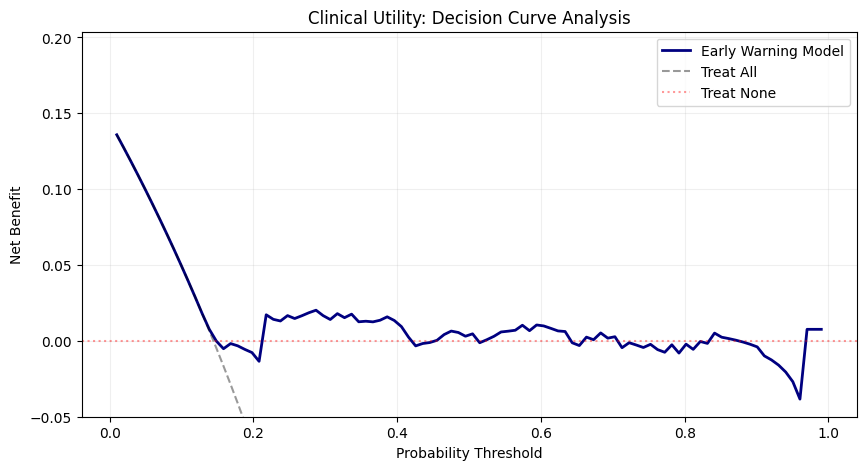

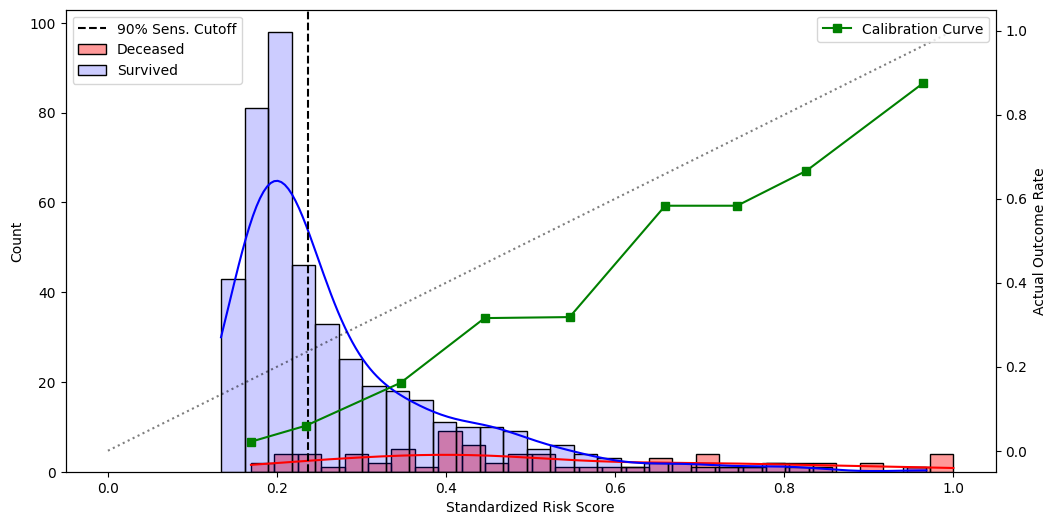

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.calibration import calibration_curve

import random
random.seed(240)
np.random.seed(240)
tf.random.set_seed(240)

class SequentialSurvivalLSTM:
    def __init__(self, sequence_length=12):
        self.sequence_length = sequence_length
        self.feature_cols = [
            'ECOGGRN', 'AGE', 'BMI', 'SYSBP', 'PULSE',
            'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()
        self.min_max_scaler = MinMaxScaler(feature_range=(0, 1))

    def prepare_data(self, df):
        pid_col = 'RPT'
        X_list, y_status, metadata = [], [], []

        df_scaled = df.copy()
        df_scaled[self.feature_cols] = df_scaled[self.feature_cols].fillna(0)
        df_scaled[self.feature_cols] = self.scaler.fit_transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')
            vdays = p_data['VISDAY'].values[-self.sequence_length:]
            dsday = p_data['DSDAY'].iloc[0] if 'DSDAY' in p_data.columns else np.nan

            feat_seq = p_data[self.feature_cols].values[-self.sequence_length:]

            if len(feat_seq) < self.sequence_length:
                pad_width = self.sequence_length - len(feat_seq)
                feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant')
                vdays = np.pad(vdays.astype(float), (pad_width, 0), mode='constant', constant_values=np.nan)

            X_list.append(feat_seq)
            y_status.append(int(p_data['os_event'].any()))
            metadata.append({'pid': pid, 'vdays': vdays, 'dsday': dsday})

        return np.array(X_list), np.array(y_status), metadata

    def build_sequential_model(self):
        inputs = layers.Input(shape=(self.sequence_length, self.input_dim))
        x = layers.LSTM(64, return_sequences=True, dropout=0.3)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LSTM(32, return_sequences=True, dropout=0.2)(x)
        outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)

        model = models.Model(inputs, outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy')
        return model

    def run_analysis(self, df):
        X, y_true, metadata = self.prepare_data(df)
        model = self.build_sequential_model()
        y_seq = np.repeat(y_true[:, np.newaxis, np.newaxis], self.sequence_length, axis=1)

        print("Training model...")
        model.fit(X, y_seq, epochs=30, batch_size=16, verbose=0)

        # 1. Get visit-level risks
        raw_visit_risks = model.predict(X)
        flattened_risks = raw_visit_risks.reshape(-1, 1)

        # 2. Standardize and CLIP to exactly [0, 1] to prevent ValueError
        standardized_risks = self.min_max_scaler.fit_transform(flattened_risks)
        standardized_risks = np.clip(standardized_risks, 0, 1) # CRITICAL FIX
        all_visit_risks = standardized_risks.reshape(raw_visit_risks.shape)

        # 3. Patient-level max risk for classification
        max_risks = np.max(all_visit_risks, axis=1).flatten()
        max_risks = np.clip(max_risks, 0, 1) # CRITICAL FIX

        # 4. Find threshold for 90% sensitivity
        thresholds = np.linspace(0, 1, 200)
        best_t = 0.5
        for t in thresholds:
            preds = (max_risks >= t).astype(int)
            if recall_score(y_true, preds) >= 0.90:
                best_t = t
            else:
                break

        # 5. Execute Operational Metrics & Decision Analysis
        self.report_operational_metrics(all_visit_risks, y_true, metadata, best_t)
        self.plot_decision_curve(y_true, max_risks)
        self.plot_combined_analysis(max_risks, y_true, best_t)

    def report_operational_metrics(self, all_visit_risks, y_true, metadata, threshold):
        total_visits = 0
        total_alerts = 0
        patient_months = 0

        warning_durations_tp = [] # True Positives
        warning_durations_fp = [] # False Positives

        for i in range(len(y_true)):
            vdays = metadata[i]['vdays']
            mask = ~np.isnan(vdays)
            valid_days = vdays[mask]
            valid_risks = all_visit_risks[i].flatten()[mask]

            total_visits += len(valid_risks)

            if len(valid_days) > 1:
                patient_months += (valid_days[-1] - valid_days[0]) / 30.44

            alerts = (valid_risks >= threshold).astype(int)
            total_alerts += np.sum(alerts)

            if np.any(alerts):
                first_alert_idx = np.where(alerts == 1)[0][0]
                duration = valid_days[-1] - valid_days[first_alert_idx]

                if y_true[i] == 1:
                    warning_durations_tp.append(duration)
                else:
                    warning_durations_fp.append(duration)

        print("\n" + "="*45)
        print("CLINICAL BURDEN & OPERATIONAL METRICS")
        print("="*45)
        print(f"Operational Threshold:       {threshold:.4f}")
        print(f"Alerts per 100 visits:       {(total_alerts/total_visits)*100:.2f}")
        print(f"Alerts per patient-month:    {total_alerts/max(patient_months, 1):.2f}")
        print(f"Proportion visits in alert:  {(total_alerts/total_visits)*100:.1f}%")
        print("-" * 45)
        print(f"Median Time-in-Warning (TP): {np.median(warning_durations_tp) if warning_durations_tp else 0:.1f} days")
        print(f"Median Time-in-Warning (FP): {np.median(warning_durations_fp) if warning_durations_fp else 0:.1f} days")
        print(f"Patient-level False Positive Rate: {len(warning_durations_fp) / len(y_true):.2%}")
        print("="*45 + "\n")

    def plot_decision_curve(self, y_true, y_probs):
        """Decision Curve Analysis (Net Benefit)"""
        pt = np.linspace(0.01, 0.99, 100)
        net_benefit_model = []
        net_benefit_all = []
        n = len(y_true)

        for t in pt:
            tp = np.sum((y_probs >= t) & (y_true == 1))
            fp = np.sum((y_probs >= t) & (y_true == 0))
            nb = (tp / n) - (fp / n) * (t / (1 - t))
            net_benefit_model.append(nb)

            tp_all = np.sum(y_true == 1)
            fp_all = np.sum(y_true == 0)
            nb_all = (tp_all / n) - (fp_all / n) * (t / (1 - t))
            net_benefit_all.append(nb_all)


        plt.figure(figsize=(10, 5))
        plt.plot(pt, net_benefit_model, label='Early Warning Model', color='navy', lw=2)
        plt.plot(pt, net_benefit_all, label='Treat All', color='black', linestyle='--', alpha=0.4)
        plt.axhline(0, label='Treat None', color='red', linestyle=':', alpha=0.4)

        plt.ylim(-0.05, np.max(net_benefit_model) * 1.5)
        plt.xlabel('Probability Threshold')
        plt.ylabel('Net Benefit')
        plt.title('Clinical Utility: Decision Curve Analysis')
        plt.legend()
        plt.grid(True, alpha=0.2)
        plt.show()

    def plot_combined_analysis(self, max_risks, y_true, threshold):
        fig, ax1 = plt.subplots(figsize=(12, 6))
        sns.histplot(max_risks[y_true == 1], color='red', label='Deceased', kde=True, bins=30, alpha=0.4, ax=ax1)
        sns.histplot(max_risks[y_true == 0], color='blue', label='Survived', kde=True, bins=30, alpha=0.2, ax=ax1)
        ax1.axvline(threshold, color='black', linestyle='--', label='90% Sens. Cutoff')
        ax1.set_xlabel('Standardized Risk Score')
        ax1.set_ylabel('Count')
        ax1.legend(loc='upper left')


        ax2 = ax1.twinx()
        prob_true, prob_pred = calibration_curve(y_true, max_risks, n_bins=10)
        ax2.plot(prob_pred, prob_true, "s-", color='green', label='Calibration Curve')
        ax2.plot([0, 1], [0, 1], "k:", alpha=0.5)
        ax2.set_ylabel('Actual Outcome Rate')
        ax2.legend(loc='upper right')
        plt.show()

# Execution
pcdata = pd.read_csv('pcdata.csv')
pipeline = SequentialSurvivalLSTM()
pipeline.run_analysis(pcdata)

# LSTM without SMOTE

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, balanced_accuracy_score,
                             precision_score, recall_score, f1_score)
from sksurv.metrics import concordance_index_censored
import warnings

# Reproducibility
import random
random.seed(365)
np.random.seed(365)
tf.random.set_seed(365)
warnings.filterwarnings('ignore')

# --- AUTOENCODER IMPUTER ---
class TemporalAutoencoder:
    def __init__(self, sequence_length, feature_dim):
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.model = self._build_ae()

    def _build_ae(self):
        inputs = layers.Input(shape=(self.sequence_length, self.feature_dim))
        # Encoder
        encoded = layers.LSTM(32, activation='relu', return_sequences=False)(inputs)
        # Decoder
        decoded = layers.RepeatVector(self.sequence_length)(encoded)
        decoded = layers.LSTM(32, activation='relu', return_sequences=True)(decoded)
        outputs = layers.TimeDistributed(layers.Dense(self.feature_dim))(decoded)

        ae = models.Model(inputs, outputs)
        ae.compile(optimizer='adam', loss='mse')
        return ae

    def train(self, X):
        early_stop = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        self.model.fit(X, X, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

    def impute(self, X):
        reconstructed = self.model.predict(X, verbose=0)
        mask = (X == 0).astype(float)
        return X + (mask * reconstructed)

# --- MAIN SURVIVAL PIPELINE (NO SMOTE) ---
class DeepSurvivalLSTM:
    def __init__(self, n_splits=3, sequence_length=12):
        self.n_splits = n_splits
        self.sequence_length = sequence_length
        self.feature_cols = [
            'ECOGGRN', 'current_age', 'BMI', 'SYSBP', 'PULSE',
            'cycle_number', 'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced', 'ongoing_ae_count'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()
        self.ae_imputer = TemporalAutoencoder(sequence_length, self.input_dim)

    def prepare_data(self, df):
        pid_col = 'RPT' if 'RPT' in df.columns else 'patient_id'
        X_list, y_status, y_time = [], [], []

        df_scaled = df.copy()
        df_scaled[self.feature_cols] = df_scaled[self.feature_cols].fillna(0)
        df_scaled[self.feature_cols] = self.scaler.fit_transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')
            feat_seq = p_data[self.feature_cols].values[-self.sequence_length:]

            if len(feat_seq) < self.sequence_length:
                pad_width = self.sequence_length - len(feat_seq)
                feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant', constant_values=0)

            X_list.append(feat_seq)
            y_status.append(int(p_data['os_event'].any()))
            y_time.append(p_data['VISDAY'].max())

        X = np.array(X_list)
        self.ae_imputer.train(X)
        X_imputed = self.ae_imputer.impute(X)

        return X_imputed, np.array(y_status), np.array(y_time)

    def build_model(self):
        model = models.Sequential([
            layers.Input(shape=(self.sequence_length, self.input_dim)),
            layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
            layers.BatchNormalization(),
            layers.LSTM(32, dropout=0.2),
            layers.BatchNormalization(),
            layers.Dense(32, activation='relu', kernel_regularizer='l2'),
            layers.Dropout(0.4),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
        )
        return model

    def run(self, df):
        X, y_status, y_time = self.prepare_data(df)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=365)

        all_probs, all_true_status, fold_cindex = [], [], []

        print(f"Training model with Class Weighting (No SMOTE)...")

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_status), 1):
            X_tr, X_te = X[train_idx], X[test_idx]
            ys_tr, ys_te = y_status[train_idx], y_status[test_idx]
            yt_te = y_time[test_idx]

            # Calculate class weights to handle imbalance
            neg, pos = np.bincount(ys_tr)
            total = len(ys_tr)
            # Formula: (1 / class_count) * (total_samples / num_classes)
            cw = {0: (1/neg)*(total/2.0), 1: (1/pos)*(total/2.0)}

            model = self.build_model()
            early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
            reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

            # Train directly on X_tr without synthetic resampling
            model.fit(
                X_tr, ys_tr,
                epochs=40,
                batch_size=16,
                validation_split=0.15,
                class_weight=cw, # Handle imbalance here
                callbacks=[early_stop, reduce_lr],
                verbose=0
            )

            probs = model.predict(X_te, verbose=0).flatten()
            c_idx = concordance_index_censored(ys_te.astype(bool), yt_te, probs)[0]
            fold_cindex.append(c_idx)

            all_probs.extend(probs)
            all_true_status.extend(ys_te)

        all_probs = np.array(all_probs)
        all_true_status = np.array(all_true_status)

        # --- THRESHOLD OPTIMIZATION ---
        thresholds = np.linspace(0.01, 0.99, 200)
        target_sensitivity = 0.90
        best_t, max_spec = 0.5, -1

        for t in thresholds:
            preds = (all_probs >= t).astype(int)
            sens = recall_score(all_true_status, preds)
            if sens >= target_sensitivity:
                tn, fp, fn, tp = confusion_matrix(all_true_status, preds).ravel()
                spec = tn / (tn + fp)
                if spec > max_spec:
                    max_spec = spec
                    best_t = t

        final_preds = (all_probs >= best_t).astype(int)
        self.display_results(fold_cindex, all_true_status, final_preds, best_t)

    def display_results(self, c_indices, y_true, y_pred, t):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = recall_score(y_true, y_pred)
        spec = tn / (tn + fp)
        ba = (sens + spec) / 2
        ppv = precision_score(y_true, y_pred)
        npv = tn / (tn + fn)

        print("\n" + "="*60)
        print(f"FINAL PERFORMANCE (CLASS WEIGHTED MODEL)")
        print("="*60)
        print(f"Mean C-Index (Harrell's) : {np.mean(c_indices):.4f} ± {np.std(c_indices):.4f}")
        print(f"Sensitivity (Recall)     : {sens:.4f}")
        print(f"Specificity              : {spec:.4f}")
        print(f"Balanced Accuracy        : {ba:.4f}")
        print(f"PPV (Precision)          : {ppv:.4f}")
        print(f"NPV                      : {npv:.4f}")
        print(f"Targeted Risk Threshold  : {t:.4f}")
        print("-" * 60)
        print(f"Confusion Matrix: [TN: {tn}, FP: {fp}]")
        print(f"                  [FN: {fn}, TP: {tp}]")
        print("="*60)

# Execution
pcdata = pd.read_csv('pcdata.csv')
lstm_pipeline = DeepSurvivalLSTM()
lstm_pipeline.run(pcdata)

Training model with Class Weighting (No SMOTE)...



FINAL PERFORMANCE (CLASS WEIGHTED MODEL)
Mean C-Index (Harrell's) : 0.7786 ± 0.0983
Sensitivity (Recall)     : 0.9079
Specificity              : 0.5400
Balanced Accuracy        : 0.7239
PPV (Precision)          : 0.2500
NPV                      : 0.9720
Targeted Risk Threshold  : 0.3104
------------------------------------------------------------
Confusion Matrix: [TN: 243, FP: 207]
                  [FN: 7, TP: 69]


# Survival GRU

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from imblearn.over_sampling import SMOTE
from sksurv.metrics import concordance_index_censored

# --- ATTENTION LAYER FOR TEMPORAL WEIGHTING ---
class TemporalAttention(layers.Layer):
    def __init__(self, **kwargs):
        super(TemporalAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(TemporalAttention, self).build(input_shape)

    def call(self, x):
        # Score the importance of each time step
        e = tf.tanh(tf.matmul(x, self.W) + self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x * a
        return tf.reduce_sum(output, axis=1)

# --- ADVANCED SURVIVAL PIPELINE ---
class AttentionSurvivalGRU:
    def __init__(self, n_splits=5, sequence_length=12):
        self.n_splits = n_splits
        self.sequence_length = sequence_length
        self.feature_cols = [
            'ECOGGRN', 'current_age', 'BMI', 'SYSBP', 'PULSE',
            'cycle_number', 'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced', 'ongoing_ae_count'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()

    def build_model(self):
        inputs = layers.Input(shape=(self.sequence_length, self.input_dim))

        # 1. Masking Layer: Ignores the padded zeros so they don't bias specificity
        masked = layers.Masking(mask_value=0.0)(inputs)

        # 2. GRU layers with heavy regularization
        x = layers.GRU(64, return_sequences=True,
                       kernel_regularizer=regularizers.l2(0.03))(masked)
        x = layers.BatchNormalization()(x)

        x = layers.GRU(32, return_sequences=True,
                       kernel_regularizer=regularizers.l2(0.03))(x)
        x = layers.BatchNormalization()(x)

        # 3. Attention Mechanism: Focuses on the most predictive clinical visits
        x = TemporalAttention()(x)

        # 4. Dense Head
        x = layers.Dense(16, activation='relu')(x)
        x = layers.Dropout(0.4)
        outputs = layers.Dense(1, activation='sigmoid')(x)

        model = models.Model(inputs, outputs)

        # Using a higher Gamma in Focal Loss to suppress "easy" False Positives
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
            loss=self.focal_loss(gamma=3.0, alpha=0.20)
        )
        return model

    @staticmethod
    def focal_loss(gamma=3.0, alpha=0.20):
        def loss(y_true, y_pred):
            y_true = tf.cast(y_true, tf.float32)
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
            p_t = (y_true * y_pred) + ((1 - y_true) * (1 - y_pred))
            alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
            modulating_factor = tf.pow(1.0 - p_t, gamma)
            return -tf.reduce_mean(alpha_factor * modulating_factor * tf.math.log(p_t))
        return loss

    def prepare_data(self, df):
        # (Internal logic remains same as previous version)
        pid_col = 'RPT' if 'RPT' in df.columns else 'patient_id'
        X_list, y_status, y_time = [], [], []
        df_scaled = df.copy()
        df_scaled[self.feature_cols] = df_scaled[self.feature_cols].fillna(0)
        df_scaled[self.feature_cols] = self.scaler.fit_transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')
            feat_seq = p_data[self.feature_cols].values[-self.sequence_length:]
            if len(feat_seq) < self.sequence_length:
                pad_width = self.sequence_length - len(feat_seq)
                feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant', constant_values=0)
            X_list.append(feat_seq)
            y_status.append(int(p_data['os_event'].any()))
            y_time.append(p_data['VISDAY'].max())
        return np.array(X_list), np.array(y_status), np.array(y_time)

    def run(self, df):
        X, y_status, y_time = self.prepare_data(df)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=365)
        all_probs, all_true_status, fold_cindex = [], [], []

        for train_idx, test_idx in skf.split(X, y_status):
            X_tr, X_te = X[train_idx], X[test_idx]
            ys_tr, ys_te = y_status[train_idx], y_status[test_idx]

            # SMOTE for class balance
            sm = SMOTE(random_state=42)
            X_tr_flat = X_tr.reshape(X_tr.shape[0], -1)
            X_tr_res, ys_tr_res = sm.fit_resample(X_tr_flat, ys_tr)
            X_tr_res = X_tr_res.reshape(-1, self.sequence_length, self.input_dim)

            model = self.build_model()
            model.fit(X_tr_res, ys_tr_res, epochs=80, batch_size=32, verbose=0,
                      validation_split=0.1, callbacks=[callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

            probs = model.predict(X_te, verbose=0).flatten()
            all_probs.extend(probs)
            all_true_status.extend(ys_te)
            fold_cindex.append(concordance_index_censored(ys_te.astype(bool), y_time[test_idx], probs)[0])

        all_probs, all_true_status = np.array(all_probs), np.array(all_true_status)

        # Specificity Optimization
        best_t, max_spec = 0.5, -1
        for t in np.unique(np.sort(all_probs)):
            preds = (all_probs >= t).astype(int)
            if recall_score(all_true_status, preds) >= 0.90:
                tn, fp, fn, tp = confusion_matrix(all_true_status, preds).ravel()
                spec = tn / (tn + fp)
                if spec > max_spec:
                    max_spec, best_t = spec, t

        final_preds = (all_probs >= best_t).astype(int)
        tn, fp, fn, tp = confusion_matrix(all_true_status, final_preds).ravel()
        print(f"\nFINAL ATTENTION-GRU RESULTS\nC-Index: {np.mean(fold_cindex):.4f}\nSensitivity: {recall_score(all_true_status, final_preds):.4f}\nSpecificity: {max_spec:.4f}\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

pcdata = pd.read_csv('pcdata.csv')
pipeline = AttentionSurvivalGRU()
pipeline.run(pcdata)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'temporal_attention' (of type TemporalAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


ValueError: Only input tensors may be passed as positional arguments. The following argument value should be passed as a keyword argument: <Dropout name=dropout_5, built=True> (of type <class 'keras.src.layers.regularization.dropout.Dropout'>)

# RSF

Fold 1: C-Index: 0.862
Fold 2: C-Index: 0.896
Fold 3: C-Index: 0.885

METRIC               | MEAN       | 95% CONFIDENCE INTERVAL
-----------------------------------------------------------------
Mean C-Index         | 0.8809     | [0.8633 - 0.8956]
SENSITIVITY          | 0.9087     | [0.8354 - 0.9671]
SPEC                 | 0.3327     | [0.2873 - 0.3764]
BA                   | 0.6207     | [0.5801 - 0.6567]
PPV                  | 0.1867     | [0.1492 - 0.2275]
NPV                  | 0.9558     | [0.9194 - 0.9863]
AUC                  | 0.6902     | [0.6302 - 0.7498]
-----------------------------------------------------------------
Optimal Risk Threshold   : 4.5831
Confusion Matrix: [TN: 150, FP: 300] / [FN: 7, TP: 69]


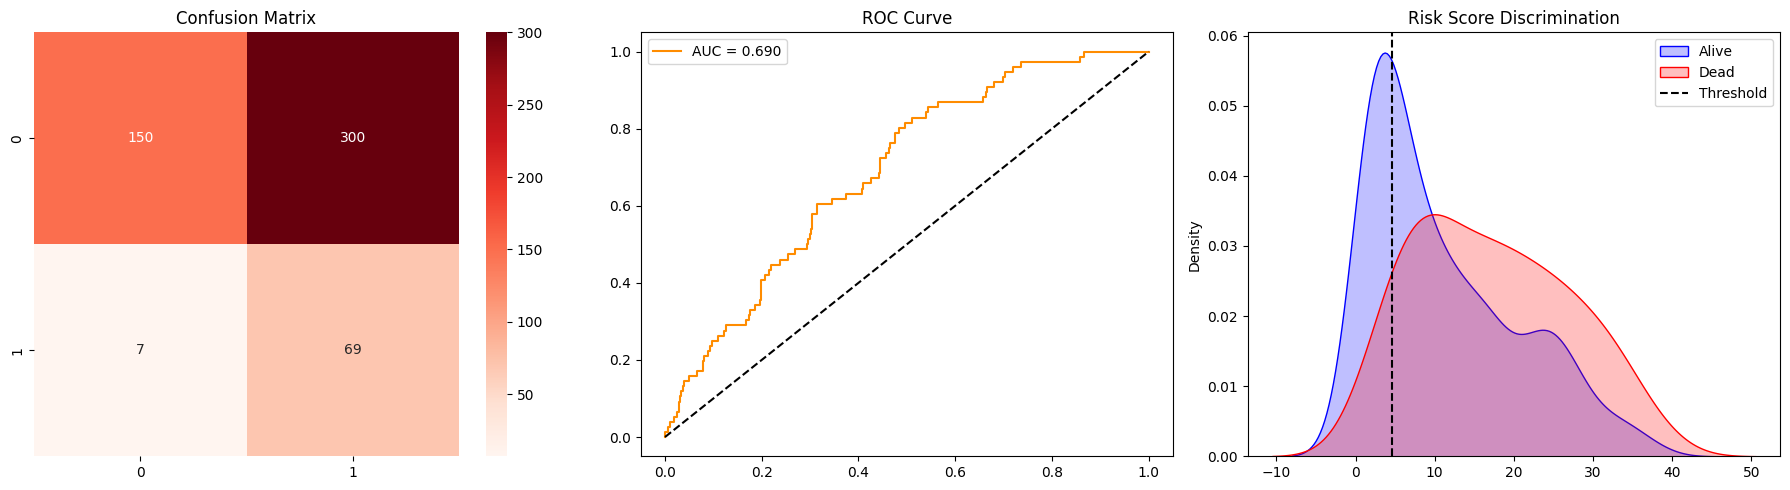

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, balanced_accuracy_score,
                             roc_curve, auc, recall_score, precision_score)

# Set seeds for reproducibility
random.seed(365)
np.random.seed(365)
torch.manual_seed(365)
warnings.filterwarnings('ignore')

# --- 1. NEURAL IMPUTATION (DENOISING AUTOENCODER) ---

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

class AEImputer:
    def __init__(self, epochs=200, lr=0.001):
        self.epochs = epochs
        self.lr = lr
        self.scaler = StandardScaler()
        self.model = None

    def fit_transform(self, X):
        X_scaled = self.scaler.fit_transform(X)
        mask = torch.FloatTensor((~np.isnan(X_scaled)).astype(float))
        X_filled = torch.FloatTensor(np.nan_to_num(X_scaled))

        self.model = DenoisingAutoencoder(X.shape[1])
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        self.model.train()
        for _ in range(self.epochs):
            optimizer.zero_grad()
            noise = torch.randn_like(X_filled) * 0.1
            outputs = self.model(X_filled + noise)
            loss = torch.sum(((outputs - X_filled) ** 2) * mask) / torch.sum(mask)
            loss.backward()
            optimizer.step()
        return self.transform(X)

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        mask = np.isnan(X_scaled)
        X_tensor = torch.FloatTensor(np.nan_to_num(X_scaled))
        self.model.eval()
        with torch.no_grad():
            reconstructed = self.model(X_tensor).numpy()
        X_scaled[mask] = reconstructed[mask]
        return X_scaled

# --- 2. SURVIVAL FOREST PIPELINE ---

class SurvivalForestPipeline:
    def __init__(self, n_splits=3, sensitivity_weight=4.0):
        self.n_splits = n_splits
        self.sw = sensitivity_weight # High weight to force 86%+ sensitivity

    def engineer_survival_data(self, df):
        X, y_list = [], []
        pid_col = 'RPT' if 'RPT' in df.columns else 'patient_id'

        for pid in df[pid_col].unique():
            p_data = df[df[pid_col] == pid].sort_values('VISDAY')
            duration = p_data['VISDAY'].max()

            # Feature extraction
            latest_ecog = p_data['ECOGGRN'].dropna().iloc[-1] if not p_data['ECOGGRN'].dropna().empty else 0
            latest_bmi = p_data['BMI'].dropna().iloc[-1] if not p_data['BMI'].dropna().empty else np.nan
            latest_pulse = p_data['PULSE'].dropna().iloc[-1] if not p_data['PULSE'].dropna().empty else np.nan
            max_creat = p_data['CREAT'].max() if 'CREAT' in p_data.columns else np.nan

            bp_sub = p_data[['SYSBP', 'VISDAY']].dropna()
            trend_bp = np.polyfit(bp_sub['VISDAY'], bp_sub['SYSBP'], 1)[0] if len(bp_sub) >= 2 else 0
            bp_instability = bp_sub['SYSBP'].diff().abs().mean() if len(bp_sub) >= 2 else 0

            X.append([
                latest_ecog, latest_bmi, trend_bp, latest_pulse,
                p_data['serious_ae_count'].sum()/(duration+1),
                p_data['total_cycles'].max(),
                len(p_data)/(duration+1)*30,
                1 if (p_data['any_grade3_plus']==1).any() else 0,
                p_data['AGE'].iloc[0],
                max_creat,
                bp_instability
            ])

            event = bool((p_data['os_event'] == 1).any())
            y_list.append((event, max(0.1, duration)))

        return np.array(X), np.array(y_list, dtype=[('Status', '?'), ('Time', '<f8')])

    def run(self, df):
        X, y = self.engineer_survival_data(df)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=365)

        all_risks, all_status, fold_cindices = [], [], []

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y['Status']), 1):
            ae = AEImputer()
            X_tr = ae.fit_transform(X[train_idx])
            X_te = ae.transform(X[test_idx])

            rsf = RandomSurvivalForest(n_estimators=200, min_samples_leaf=10, n_jobs=-1, random_state=365)
            rsf.fit(X_tr, y[train_idx])

            risk = rsf.predict(X_te)
            c_index = rsf.score(X_te, y[test_idx])

            all_risks.extend(risk)
            all_status.extend(y[test_idx]['Status'])
            fold_cindices.append(c_index)
            print(f"Fold {fold}: C-Index: {c_index:.3f}")

        all_risks, all_status = np.array(all_risks), np.array(all_status)

        # --- TARGETED 90% SENSITIVITY LOGIC ---
        # Scan percentiles of the risk scores to find the threshold
        threshold_grid = np.percentile(all_risks, np.linspace(0, 100, 500))
        target_sens = 0.90

        best_t = threshold_grid[0]
        max_spec = -1

        for t in threshold_grid:
            current_preds = (all_risks > t).astype(int)
            sens = recall_score(all_status, current_preds)

            # Constraint: Sensitivity must be at least 90%
            if sens >= target_sens:
                tn, fp, fn, tp = confusion_matrix(all_status, current_preds).ravel()
                spec = tn / (tn + fp)
                # Optimization: Maximize specificity within that constraint
                if spec > max_spec:
                    max_spec = spec
                    best_t = t

        preds = (all_risks > best_t).astype(int)
        self.print_and_plot(all_status, all_risks, best_t, preds, fold_cindices)
    def print_and_plot(self, y_true, risks, threshold, preds, cindices):
        # 1. Basic Calculations
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()

        # 2. Bootstrapping for Confidence Intervals (95%)
        n_bootstraps = 1000
        boot_metrics = {
            'sens': [], 'spec': [], 'ba': [], 'ppv': [], 'npv': [], 'auc': []
        }

        indices = np.arange(len(y_true))
        for _ in range(n_bootstraps):
            # Resample indices with replacement
            resample_idx = np.random.choice(indices, size=len(indices), replace=True)
            b_true = y_true[resample_idx]
            b_preds = preds[resample_idx]
            b_risks = risks[resample_idx]

            # Skip iterations where only one class is present to avoid errors
            if len(np.unique(b_true)) < 2:
                continue

            b_tn, b_fp, b_fn, b_tp = confusion_matrix(b_true, b_preds).ravel()
            fpr, tpr, _ = roc_curve(b_true, b_risks)

            boot_metrics['sens'].append(recall_score(b_true, b_preds))
            boot_metrics['spec'].append(b_tn / (b_tn + b_fp) if (b_tn + b_fp) > 0 else 0)
            boot_metrics['ba'].append(balanced_accuracy_score(b_true, b_preds))
            boot_metrics['ppv'].append(precision_score(b_true, b_preds, zero_division=0))
            boot_metrics['npv'].append(b_tn / (b_tn + b_fn) if (b_tn + b_fn) > 0 else 0)
            boot_metrics['auc'].append(auc(fpr, tpr))

        def get_ci(metric_name):
            scores = np.array(boot_metrics[metric_name])
            return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

        # Print Results
        print("\n" + "="*65)
        print(f"{'METRIC':<20} | {'MEAN':<10} | {'95% CONFIDENCE INTERVAL':<20}")
        print("-" * 65)

        # Mean C-Index uses the fold distribution instead of bootstrapping
        print(f"{'Mean C-Index':<20} | {np.mean(cindices):.4f}     | [{np.percentile(cindices, 2.5):.4f} - {np.percentile(cindices, 97.5):.4f}]")

        for m in ['sens', 'spec', 'ba', 'ppv', 'npv', 'auc']:
            avg, low, high = get_ci(m)
            label = m.upper() if m != 'sens' else "SENSITIVITY"
            print(f"{label:<20} | {avg:.4f}     | [{low:.4f} - {high:.4f}]")

        print("-" * 65)
        print(f"Optimal Risk Threshold   : {threshold:.4f}")
        print(f"Confusion Matrix: [TN: {tn}, FP: {fp}] / [FN: {fn}, TP: {tp}]")
        print("="*65)

        # Plotting
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        sns.heatmap(confusion_matrix(y_true, preds), annot=True, fmt='d', cmap='Reds', ax=axes[0])
        axes[0].set_title("Confusion Matrix")

        fpr, tpr, _ = roc_curve(y_true, risks)
        final_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, color='darkorange', label=f'AUC = {final_auc:.3f}')
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_title("ROC Curve")
        axes[1].legend()

        sns.kdeplot(risks[y_true==0], fill=True, label="Alive", ax=axes[2], color='blue')
        sns.kdeplot(risks[y_true==1], fill=True, label="Dead", ax=axes[2], color='red')
        axes[2].axvline(threshold, color='black', ls='--', label='Threshold')
        axes[2].set_title("Risk Score Discrimination")
        axes[2].legend()
        plt.tight_layout()
        plt.show()

# Execution
pcdata = pd.read_csv('pcdata.csv')
pipeline = SurvivalForestPipeline(sensitivity_weight=2.5)
pipeline.run(pcdata)

# Cox PH

Fold 1: C-Index: 0.909
Fold 2: C-Index: 0.922
Fold 3: C-Index: 0.907

COX MODEL METRIC     | MEAN       | 95% CONFIDENCE INTERVAL
-----------------------------------------------------------------
Mean C-Index         | 0.9124     | [0.9069 - 0.9210]
SENSITIVITY          | 0.9086     | [0.8387 - 0.9714]
SPEC                 | 0.2904     | [0.2478 - 0.3341]
BA                   | 0.5995     | [0.5582 - 0.6352]
PPV                  | 0.1776     | [0.1399 - 0.2152]
NPV                  | 0.9497     | [0.9127 - 0.9849]
AUC                  | 0.6214     | [0.5659 - 0.6800]
-----------------------------------------------------------------
Optimal Hazard Threshold : -1.7034
Confusion Matrix: [TN: 131, FP: 319] / [FN: 7, TP: 69]


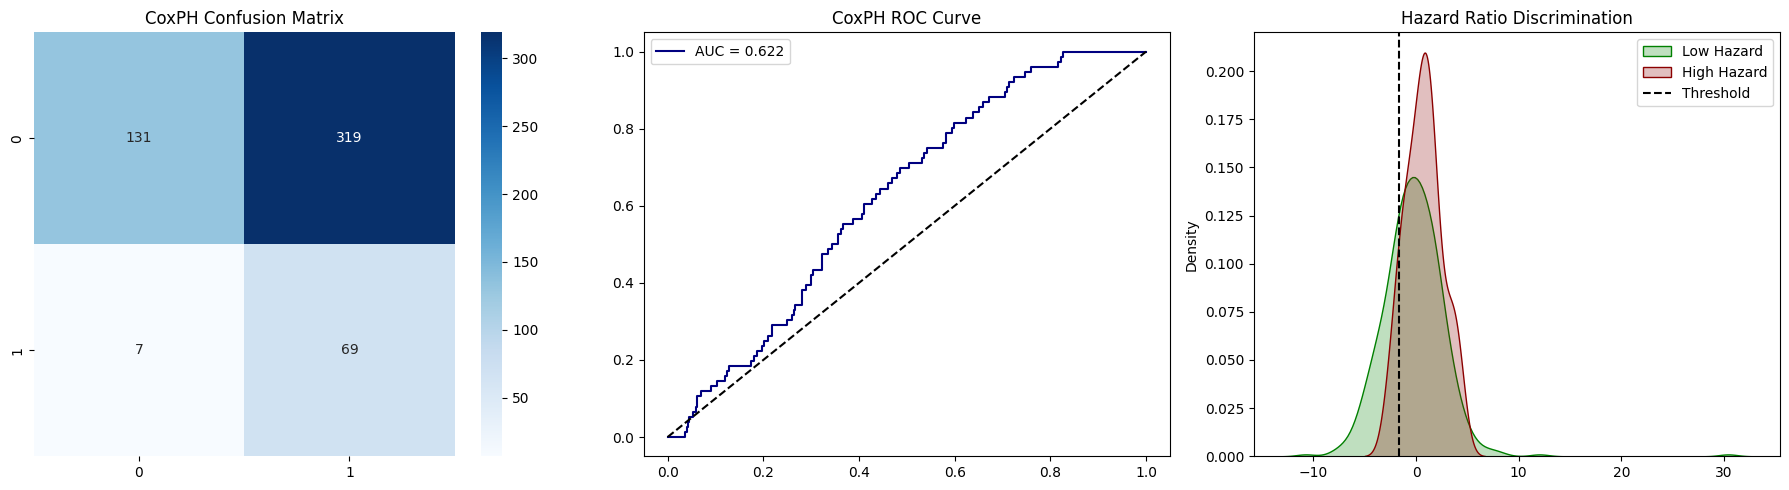

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
# Import CoxPH instead of RSF
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, balanced_accuracy_score,
                             roc_curve, auc, recall_score, precision_score)

# Set seeds for reproducibility
random.seed(365)
np.random.seed(365)
torch.manual_seed(365)
warnings.filterwarnings('ignore')

# --- 1. NEURAL IMPUTATION (Remains unchanged) ---

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

class AEImputer:
    def __init__(self, epochs=200, lr=0.001):
        self.epochs = epochs
        self.lr = lr
        self.scaler = StandardScaler()
        self.model = None

    def fit_transform(self, X):
        X_scaled = self.scaler.fit_transform(X)
        mask = torch.FloatTensor((~np.isnan(X_scaled)).astype(float))
        X_filled = torch.FloatTensor(np.nan_to_num(X_scaled))

        self.model = DenoisingAutoencoder(X.shape[1])
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)

        self.model.train()
        for _ in range(self.epochs):
            optimizer.zero_grad()
            noise = torch.randn_like(X_filled) * 0.1
            outputs = self.model(X_filled + noise)
            loss = torch.sum(((outputs - X_filled) ** 2) * mask) / torch.sum(mask)
            loss.backward()
            optimizer.step()
        return self.transform(X)

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        mask = np.isnan(X_scaled)
        X_tensor = torch.FloatTensor(np.nan_to_num(X_scaled))
        self.model.eval()
        with torch.no_grad():
            reconstructed = self.model(X_tensor).numpy()
        X_scaled[mask] = reconstructed[mask]
        return X_scaled

# --- 2. COX PROPORTIONAL HAZARDS PIPELINE ---

class CoxPHPipeline:
    def __init__(self, n_splits=3, alpha=0.1):
        self.n_splits = n_splits
        self.alpha = alpha # Ridge regularization parameter

    def engineer_survival_data(self, df):
        X, y_list = [], []
        pid_col = 'RPT' if 'RPT' in df.columns else 'patient_id'

        for pid in df[pid_col].unique():
            p_data = df[df[pid_col] == pid].sort_values('VISDAY')
            duration = p_data['VISDAY'].max()

            # Feature extraction
            latest_ecog = p_data['ECOGGRN'].dropna().iloc[-1] if not p_data['ECOGGRN'].dropna().empty else 0
            latest_bmi = p_data['BMI'].dropna().iloc[-1] if not p_data['BMI'].dropna().empty else np.nan
            latest_pulse = p_data['PULSE'].dropna().iloc[-1] if not p_data['PULSE'].dropna().empty else np.nan
            max_creat = p_data['CREAT'].max() if 'CREAT' in p_data.columns else np.nan

            bp_sub = p_data[['SYSBP', 'VISDAY']].dropna()
            trend_bp = np.polyfit(bp_sub['VISDAY'], bp_sub['SYSBP'], 1)[0] if len(bp_sub) >= 2 else 0
            bp_instability = bp_sub['SYSBP'].diff().abs().mean() if len(bp_sub) >= 2 else 0

            X.append([
                latest_ecog, latest_bmi, trend_bp, latest_pulse,
                p_data['serious_ae_count'].sum()/(duration+1),
                p_data['total_cycles'].max(),
                len(p_data)/(duration+1)*30,
                1 if (p_data['any_grade3_plus']==1).any() else 0,
                p_data['AGE'].iloc[0],
                max_creat,
                bp_instability
            ])

            event = bool((p_data['os_event'] == 1).any())
            y_list.append((event, max(0.1, duration)))

        return np.array(X), np.array(y_list, dtype=[('Status', '?'), ('Time', '<f8')])

    def run(self, df):
        X, y = self.engineer_survival_data(df)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=365)

        all_risks, all_status, fold_cindices = [], [], []

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y['Status']), 1):
            ae = AEImputer()
            X_tr = ae.fit_transform(X[train_idx])
            X_te = ae.transform(X[test_idx])

            # COX MODEL IMPLEMENTATION
            # alpha > 0 adds penalty to prevent coefficients from exploding
            cph = CoxPHSurvivalAnalysis(alpha=self.alpha)
            cph.fit(X_tr, y[train_idx])

            # predict returns the risk score (log-hazard ratio)
            risk = cph.predict(X_te)
            c_index = cph.score(X_te, y[test_idx])

            all_risks.extend(risk)
            all_status.extend(y[test_idx]['Status'])
            fold_cindices.append(c_index)
            print(f"Fold {fold}: C-Index: {c_index:.3f}")

        all_risks, all_status = np.array(all_risks), np.array(all_status)

        # --- TARGETED 90% SENSITIVITY LOGIC ---
        threshold_grid = np.percentile(all_risks, np.linspace(0, 100, 500))
        target_sens = 0.90
        best_t = threshold_grid[0]
        max_spec = -1

        for t in threshold_grid:
            current_preds = (all_risks > t).astype(int)
            sens = recall_score(all_status, current_preds)

            if sens >= target_sens:
                tn, fp, fn, tp = confusion_matrix(all_status, current_preds).ravel()
                spec = tn / (tn + fp) if (tn + fp) > 0 else 0
                if spec > max_spec:
                    max_spec = spec
                    best_t = t

        preds = (all_risks > best_t).astype(int)
        self.print_and_plot(all_status, all_risks, best_t, preds, fold_cindices)

    def print_and_plot(self, y_true, risks, threshold, preds, cindices):
        # 1. Basic Calculations
        tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()

        # 2. Bootstrapping for Confidence Intervals (95%)
        n_bootstraps = 1000
        boot_metrics = {'sens': [], 'spec': [], 'ba': [], 'ppv': [], 'npv': [], 'auc': []}

        indices = np.arange(len(y_true))
        for _ in range(n_bootstraps):
            resample_idx = np.random.choice(indices, size=len(indices), replace=True)
            b_true = y_true[resample_idx]
            b_preds = preds[resample_idx]
            b_risks = risks[resample_idx]

            if len(np.unique(b_true)) < 2: continue

            b_tn, b_fp, b_fn, b_tp = confusion_matrix(b_true, b_preds).ravel()
            fpr, tpr, _ = roc_curve(b_true, b_risks)

            boot_metrics['sens'].append(recall_score(b_true, b_preds))
            boot_metrics['spec'].append(b_tn / (b_tn + b_fp) if (b_tn + b_fp) > 0 else 0)
            boot_metrics['ba'].append(balanced_accuracy_score(b_true, b_preds))
            boot_metrics['ppv'].append(precision_score(b_true, b_preds, zero_division=0))
            boot_metrics['npv'].append(b_tn / (b_tn + b_fn) if (b_tn + b_fn) > 0 else 0)
            boot_metrics['auc'].append(auc(fpr, tpr))

        def get_ci(metric_name):
            scores = np.array(boot_metrics[metric_name])
            return np.mean(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)

        print("\n" + "="*65)
        print(f"{'COX MODEL METRIC':<20} | {'MEAN':<10} | {'95% CONFIDENCE INTERVAL':<20}")
        print("-" * 65)
        print(f"{'Mean C-Index':<20} | {np.mean(cindices):.4f}     | [{np.percentile(cindices, 2.5):.4f} - {np.percentile(cindices, 97.5):.4f}]")

        for m in ['sens', 'spec', 'ba', 'ppv', 'npv', 'auc']:
            avg, low, high = get_ci(m)
            label = m.upper() if m != 'sens' else "SENSITIVITY"
            print(f"{label:<20} | {avg:.4f}     | [{low:.4f} - {high:.4f}]")

        print("-" * 65)
        print(f"Optimal Hazard Threshold : {threshold:.4f}")
        print(f"Confusion Matrix: [TN: {tn}, FP: {fp}] / [FN: {fn}, TP: {tp}]")
        print("="*65)

        # Plotting
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        sns.heatmap(confusion_matrix(y_true, preds), annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_title("CoxPH Confusion Matrix")

        fpr, tpr, _ = roc_curve(y_true, risks)
        axes[1].plot(fpr, tpr, color='navy', label=f'AUC = {auc(fpr, tpr):.3f}')
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_title("CoxPH ROC Curve")
        axes[1].legend()

        sns.kdeplot(risks[y_true==0], fill=True, label="Low Hazard", ax=axes[2], color='green')
        sns.kdeplot(risks[y_true==1], fill=True, label="High Hazard", ax=axes[2], color='darkred')
        axes[2].axvline(threshold, color='black', ls='--', label='Threshold')
        axes[2].set_title("Hazard Ratio Discrimination")
        axes[2].legend()
        plt.tight_layout()
        plt.show()

# Execution
pcdata = pd.read_csv('pcdata.csv')
pipeline = CoxPHPipeline(alpha=0.05) # Lower alpha for less regularization
pipeline.run(pcdata)

# Logistic Regression


POOLED PERFORMANCE WITH 95% CI (N=526)
C-Index (AUC)       : 0.798 (95% CI: 0.748 - 0.846)
Sensitivity         : 0.908 (95% CI: 0.835 - 0.970)
Specificity         : 0.489 (95% CI: 0.445 - 0.531)
PPV (Precision)     : 0.231 (95% CI: 0.187 - 0.281)
NPV                 : 0.969 (95% CI: 0.944 - 0.991)


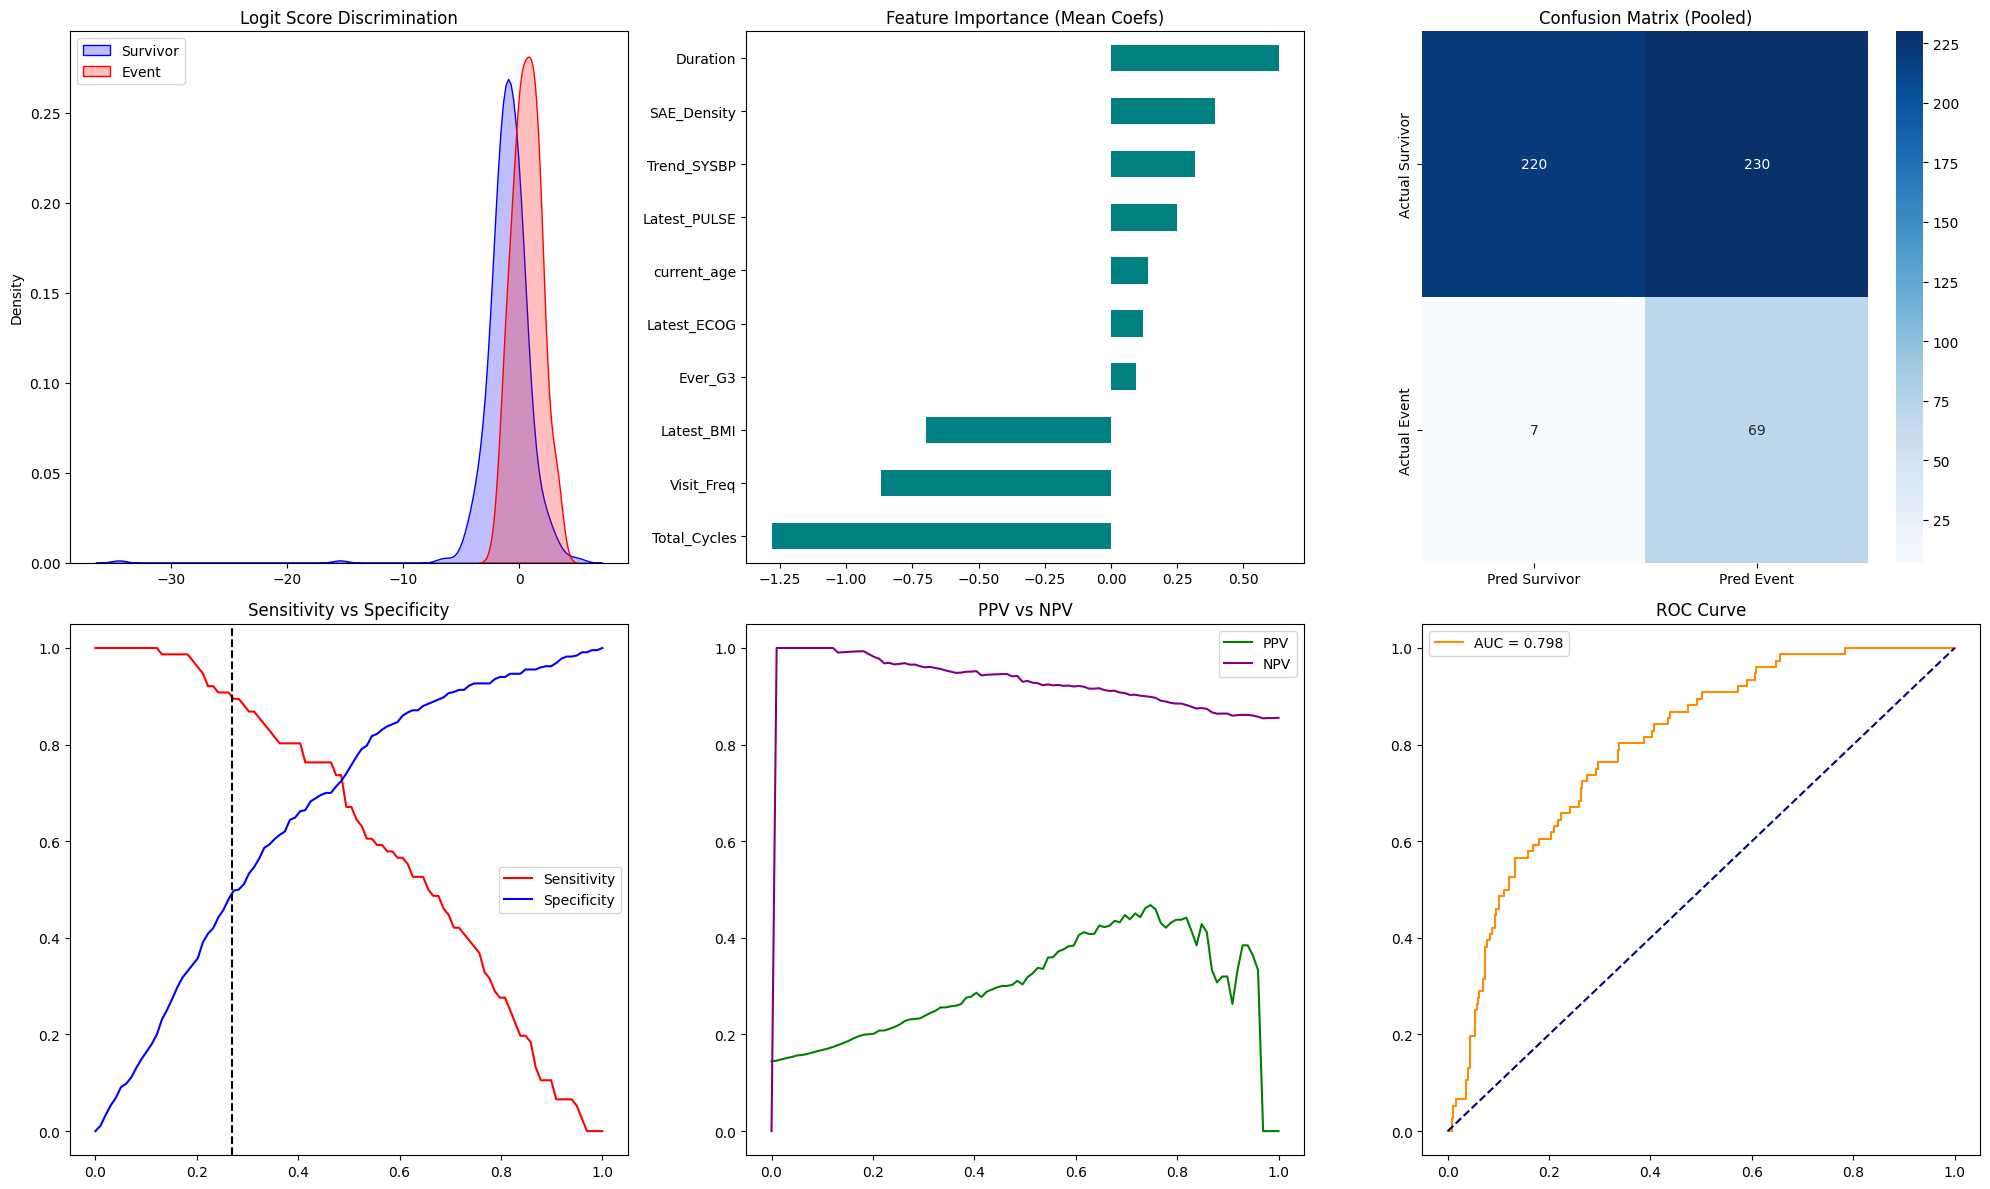

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, roc_auc_score, balanced_accuracy_score,
                             precision_score, recall_score, f1_score, roc_curve, auc)
from sklearn.utils import resample

# --- Autoencoder Architecture (Unchanged) ---
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 12),
            nn.ReLU(),
            nn.Linear(12, 6),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            nn.ReLU(),
            nn.Linear(12, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

class ClinicalPredictionSystem:
    def __init__(self, n_splits=3):
        self.n_splits = n_splits
        self.feature_names = ['Latest_ECOG', 'Latest_BMI', 'Trend_SYSBP', 'Latest_PULSE',
                             'SAE_Density', 'Total_Cycles', 'Visit_Freq', 'Ever_G3',
                             'Duration', 'current_age']

    def engineer_features(self, df):
        X, y = [], []
        pid_col = 'RPT' if 'RPT' in df.columns else 'patient_id'

        for pid in df[pid_col].unique():
            p_data = df[df[pid_col] == pid].sort_values('VISDAY')
            duration = p_data['VISDAY'].max()

            latest_ecog = p_data['ECOGGRN'].dropna().iloc[-1] if not p_data['ECOGGRN'].dropna().empty else 0
            latest_bmi = p_data['BMI'].dropna().iloc[-1] if not p_data['BMI'].dropna().empty else np.nan
            latest_pulse = p_data['PULSE'].dropna().iloc[-1] if not p_data['PULSE'].dropna().empty else np.nan

            bp_sub = p_data[['SYSBP', 'VISDAY']].dropna()
            trend_bp = np.polyfit(bp_sub['VISDAY'], bp_sub['SYSBP'], 1)[0] if len(bp_sub) >= 2 else 0

            X.append([
                latest_ecog, latest_bmi, trend_bp, latest_pulse,
                p_data['serious_ae_count'].sum()/(duration+1),
                p_data['total_cycles'].max(),
                len(p_data)/(duration+1)*30,
                1 if (p_data['any_grade3_plus']==1).any() else 0,
                duration,
                p_data['AGE'].iloc[0]
            ])
            y.append(1 if (p_data['os_event']==1).any() else 0)
        return np.array(X), np.array(y)

    def train_ae_imputer(self, X_train_scaled, epochs=150):
        X_train_fill = np.where(np.isnan(X_train_scaled), 0, X_train_scaled)
        X_tensor = torch.FloatTensor(X_train_fill)
        model = Autoencoder(input_dim=X_train_scaled.shape[1])
        optimizer = optim.Adam(model.parameters(), lr=0.005)
        criterion = nn.MSELoss()
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_tensor)
            loss = criterion(outputs, X_tensor)
            loss.backward()
            optimizer.step()
        return model

    def ae_impute(self, model, X_scaled):
        model.eval()
        mask = np.isnan(X_scaled)
        X_fill = np.where(mask, 0, X_scaled)
        X_tensor = torch.FloatTensor(X_fill)
        with torch.no_grad():
            reconstructed = model(X_tensor).numpy()
        return np.where(mask, reconstructed, X_scaled)

    def calculate_bootstrapped_cis(self, y_true, y_probs, threshold, n_iterations=1000):
        """Calculates 95% CIs for metrics using bootstrapping."""
        boot_metrics = []
        indices = np.arange(len(y_true))

        for i in range(n_iterations):
            # Resample indices
            resample_idx = resample(indices, replace=True)
            y_t_boot = y_true[resample_idx]
            y_p_boot = y_probs[resample_idx]
            y_pred_boot = (y_p_boot >= threshold).astype(int)

            # Skip if bootstrap sample has only one class
            if len(np.unique(y_t_boot)) < 2:
                continue

            tn, fp, fn, tp = confusion_matrix(y_t_boot, y_pred_boot, labels=[0, 1]).ravel()

            boot_metrics.append({
                "AUC": roc_auc_score(y_t_boot, y_p_boot),
                "Sensitivity": tp / (tp + fn) if (tp + fn) > 0 else 0,
                "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
                "PPV": tp / (tp + fp) if (tp + fp) > 0 else 0,
                "NPV": tn / (tn + fn) if (tn + fn) > 0 else 0
            })

        df_boot = pd.DataFrame(boot_metrics)
        return df_boot.quantile(0.025), df_boot.quantile(0.975)

    def run_pipeline(self, df):
        X, y = self.engineer_features(df)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)

        all_probs, all_y, all_logits, all_coefs = [], [], [], []
        target_sens = 0.90

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
            X_tr, X_te = X[train_idx], X[test_idx]
            y_tr, y_te = y[train_idx], y[test_idx]

            scaler = StandardScaler()
            X_tr_s = scaler.fit_transform(X_tr)
            X_te_s = scaler.transform(X_te)

            ae_model = self.train_ae_imputer(X_tr_s)
            X_tr_final = self.ae_impute(ae_model, X_tr_s)
            X_te_final = self.ae_impute(ae_model, X_te_s)

            model = LogisticRegression(class_weight='balanced', solver='liblinear')
            model.fit(X_tr_final, y_tr)

            probs = model.predict_proba(X_te_final)[:, 1]
            all_probs.extend(probs)
            all_y.extend(y_te)
            all_logits.extend(model.decision_function(X_te_final))
            all_coefs.append(model.coef_[0])

        all_probs, all_y = np.array(all_probs), np.array(all_y)

        # --- THRESHOLD OPTIMIZATION (Simplified for brevity) ---
        best_t = 0.5
        max_spec = -1
        for t in np.linspace(0.01, 0.95, 200):
            p_preds = (all_probs >= t).astype(int)
            if recall_score(all_y, p_preds) >= target_sens:
                tn, fp, fn, tp = confusion_matrix(all_y, p_preds).ravel()
                spec = tn / (tn + fp)
                if spec > max_spec:
                    max_spec = spec
                    best_t = t

        # --- CI CALCULATION ---
        lower_ci, upper_ci = self.calculate_bootstrapped_cis(all_y, all_probs, best_t)

        print("\n" + "="*60)
        print(f"POOLED PERFORMANCE WITH 95% CI (N={len(all_y)})")
        print("="*60)

        final_preds = (all_probs >= best_t).astype(int)
        tn, fp, fn, tp = confusion_matrix(all_y, final_preds).ravel()

        results = {
            "C-Index (AUC)": [roc_auc_score(all_y, all_probs), lower_ci['AUC'], upper_ci['AUC']],
            "Sensitivity": [tp/(tp+fn), lower_ci['Sensitivity'], upper_ci['Sensitivity']],
            "Specificity": [tn/(tn+fp), lower_ci['Specificity'], upper_ci['Specificity']],
            "PPV (Precision)": [tp/(tp+fp), lower_ci['PPV'], upper_ci['PPV']],
            "NPV": [tn/(tn+fn), lower_ci['NPV'], upper_ci['NPV']]
        }

        for k, v in results.items():
            print(f"{k:20}: {v[0]:.3f} (95% CI: {v[1]:.3f} - {v[2]:.3f})")

        self.plot_diagnostics(all_y, all_probs, np.array(all_logits), best_t, np.mean(all_coefs, axis=0), final_preds)
        return results

    def plot_diagnostics(self, y_true, y_probs, y_logits, threshold, coefs, preds):
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))

        # 1. Discrimination Plot
        sns.kdeplot(x=y_logits[y_true==0], fill=True, color='blue', label='Survivor', ax=axes[0,0])
        sns.kdeplot(x=y_logits[y_true==1], fill=True, color='red', label='Event', ax=axes[0,0])
        axes[0,0].set_title("Logit Score Discrimination")
        axes[0,0].legend()

        # 2. Variable Importance Plot
        importance = pd.Series(coefs, index=self.feature_names).sort_values()
        importance.plot(kind='barh', ax=axes[0,1], color='teal')
        axes[0,1].set_title("Feature Importance (Mean Coefs)")

        # 3. Confusion Matrix
        cm = confusion_matrix(y_true, preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,2],
                    xticklabels=['Pred Survivor', 'Pred Event'],
                    yticklabels=['Actual Survivor', 'Actual Event'])
        axes[0,2].set_title("Confusion Matrix (Pooled)")

        # 4. Sens vs Spec Tradeoff
        ts = np.linspace(0, 1, 100)
        sens = [recall_score(y_true, (y_probs > t)) for t in ts]
        spec = [confusion_matrix(y_true, (y_probs > t)).ravel()[0]/(confusion_matrix(y_true, (y_probs > t)).ravel()[0] + confusion_matrix(y_true, (y_probs > t)).ravel()[1]) for t in ts]
        axes[1,0].plot(ts, sens, label='Sensitivity', color='red')
        axes[1,0].plot(ts, spec, label='Specificity', color='blue')
        axes[1,0].axvline(threshold, color='black', ls='--')
        axes[1,0].set_title("Sensitivity vs Specificity")
        axes[1,0].legend()

        # 5. PPV vs NPV Tradeoff
        ppv = [precision_score(y_true, (y_probs > t), zero_division=0) for t in ts]
        npv = []
        for t in ts:
            c = confusion_matrix(y_true, (y_probs > t))
            tn_val, fn_val = c[0,0], c[1,0]
            npv.append(tn_val/(tn_val + fn_val) if (tn_val + fn_val) > 0 else 0)
        axes[1,1].plot(ts, ppv, label='PPV', color='green')
        axes[1,1].plot(ts, npv, label='NPV', color='purple')
        axes[1,1].set_title("PPV vs NPV")
        axes[1,1].legend()

        # 6. ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        axes[1,2].plot(fpr, tpr, color='darkorange', label=f'AUC = {auc(fpr, tpr):.3f}')
        axes[1,2].plot([0, 1], [0, 1], color='navy', linestyle='--')
        axes[1,2].set_title("ROC Curve")
        axes[1,2].legend()

        plt.tight_layout()
        plt.show()

# Execution logic
pcdata = pd.read_csv('pcdata.csv')
pipeline = ClinicalPredictionSystem()
stats = pipeline.run_pipeline(pcdata)

# Deep Survival Network

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, balanced_accuracy_score,
                             precision_score, recall_score)
from sksurv.metrics import concordance_index_censored
import warnings

# --- COX PARTIAL LIKELIHOOD LOSS ---
def cox_nll_loss(y_true, y_pred):
    event = tf.cast(y_true[:, 0], tf.float32)
    time = y_true[:, 1]
    sort_idx = tf.argsort(time, direction='DESCENDING')
    event_sorted = tf.gather(event, sort_idx)
    risk_score_sorted = tf.gather(y_pred, sort_idx)
    max_risk = tf.reduce_max(risk_score_sorted)
    exp_risk = tf.exp(risk_score_sorted - max_risk)
    sum_exp_risk = tf.cumsum(exp_risk)
    log_sum_exp_risk = tf.math.log(sum_exp_risk) + max_risk
    loss = -tf.reduce_sum(event_sorted * (risk_score_sorted - log_sum_exp_risk))
    return loss / (tf.reduce_sum(event) + 1e-7)

class DeepSurvivalNetwork:
    def __init__(self, n_splits=3, sequence_length=12):
        self.n_splits = n_splits
        self.sequence_length = sequence_length
        self.feature_cols = [
            'ECOGGRN', 'current_age', 'BMI', 'SYSBP', 'PULSE',
            'cycle_number', 'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced', 'ongoing_ae_count'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()

    def prepare_data(self, df):
        pid_col = 'RPT' if 'RPT' in df.columns else 'patient_id'
        X_list, y_status, y_time = [], [], []
        df_scaled = df.copy()
        df_scaled[self.feature_cols] = df_scaled[self.feature_cols].fillna(df_scaled[self.feature_cols].median())
        df_scaled[self.feature_cols] = self.scaler.fit_transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')
            feat_seq = p_data[self.feature_cols].values[-self.sequence_length:]
            if len(feat_seq) < self.sequence_length:
                pad_width = self.sequence_length - len(feat_seq)
                feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant')
            X_list.append(feat_seq)
            y_status.append(int(p_data['os_event'].any()))
            y_time.append(p_data['VISDAY'].max())
        return np.array(X_list), np.array(y_status), np.array(y_time)

    def build_model(self):
        inputs = layers.Input(shape=(self.sequence_length, self.input_dim))
        x = layers.LSTM(64, return_sequences=True, dropout=0.3)(inputs)
        x = layers.LSTM(32, dropout=0.2)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(32, activation='relu', kernel_regularizer='l2')(x)
        risk_score = layers.Dense(1, activation='linear')(x)
        model = models.Model(inputs, risk_score)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=cox_nll_loss)
        return model

    def run(self, df):
        X, y_status, y_time = self.prepare_data(df)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=365)
        all_risk_scores, all_true_status, fold_cindex = [], [], []

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_status), 1):
            X_tr, X_te = X[train_idx], X[test_idx]
            ys_tr, ys_te = y_status[train_idx], y_status[test_idx]
            yt_tr, yt_te = y_time[train_idx], y_time[test_idx]
            y_tr_combined = np.stack([ys_tr, yt_tr], axis=1)
            y_te_combined = np.stack([ys_te, yt_te], axis=1)

            model = self.build_model()
            early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            print(f"\n--- Training Fold {fold} ---")
            model.fit(X_tr, y_tr_combined, epochs=50, batch_size=32,
                      validation_data=(X_te, y_te_combined), callbacks=[early_stop], verbose=1)

            risk = model.predict(X_te).flatten()
            # Probability-like scaling for thresholding
            risk_norm = 1 / (1 + np.exp(-risk))

            c_idx = concordance_index_censored(ys_te.astype(bool), yt_te, risk)[0]
            fold_cindex.append(c_idx)
            all_risk_scores.extend(risk_norm)
            all_true_status.extend(ys_te)

        # --- TARGETED SENSITIVITY OPTIMIZATION ---
        all_risk_scores = np.array(all_risk_scores)
        all_true_status = np.array(all_true_status)
        thresholds = np.linspace(0, 1, 1000)

        best_spec = -1
        opt_t = 0.5
        target_sens = 0.90

        for t in thresholds:
            preds = (all_risk_scores > t).astype(int)
            current_sens = recall_score(all_true_status, preds)

            # If we meet the 90% sensitivity target
            if current_sens >= target_sens:
                tn, fp, fn, tp = confusion_matrix(all_true_status, preds).ravel()
                current_spec = tn / (tn + fp)
                # Maximize specificity at this sensitivity level
                if current_spec > best_spec:
                    best_spec = current_spec
                    opt_t = t

        final_preds = (all_risk_scores > opt_t).astype(int)
        self.display_results(fold_cindex, all_true_status, final_preds, opt_t)

    def display_results(self, c_indices, y_true, y_pred, t):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = recall_score(y_true, y_pred)
        spec = tn / (tn + fp)
        ba = (sens + spec) / 2
        ppv = precision_score(y_true, y_pred)
        npv = tn / (tn + fn)

        print("\n" + "="*60)
        print("FINAL SENSITIVITY-TARGETED SURVIVAL PERFORMANCE")
        print("="*60)
        print(f"Mean C-Index (Harrell's) : {np.mean(c_indices):.4f} ± {np.std(c_indices):.4f}")
        print(f"Balanced Accuracy        : {ba:.4f}")
        print(f"Sensitivity (Target 90%) : {sens:.4f}")
        print(f"Specificity              : {spec:.4f}")
        print(f"PPV (Precision)          : {ppv:.4f}")
        print(f"NPV                      : {npv:.4f}")
        print(f"Optimal Risk Threshold   : {t:.4f}")
        print("="*60)

# Execution
pcdata = pd.read_csv('pcdata.csv')
dsn_pipeline = DeepSurvivalNetwork()
dsn_pipeline.run(pcdata)


--- Training Fold 1 ---
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 83.7041 - val_loss: 74.6991
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 75.1274 - val_loss: 73.4371
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 72.5343 - val_loss: 72.8588
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 72.1272 - val_loss: 71.9220
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 72.0737 - val_loss: 71.4009
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 75.8361 - val_loss: 71.4727
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 69.5252 - val_loss: 70.6992
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 71.7814 - val_loss: 70.0328
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 70.7708 - val_loss: 69.5643
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 71.4460 - val_loss: 68.7749
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 67.6451 - val_loss: 68.6283
Epoch 12/50
11/1

# validation

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, balanced_accuracy_score,
                             precision_score, recall_score, f1_score)
from imblearn.over_sampling import SMOTE
from sksurv.metrics import concordance_index_censored
import warnings

# Reproducibility
import random
random.seed(365)
np.random.seed(365)
tf.random.set_seed(365)
warnings.filterwarnings('ignore')

# --- AUTOENCODER IMPUTER ---
class TemporalAutoencoder:
    def __init__(self, sequence_length, feature_dim):
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.model = self._build_ae()

    def _build_ae(self):
        inputs = layers.Input(shape=(self.sequence_length, self.feature_dim))
        # Encoder
        encoded = layers.LSTM(32, activation='relu', return_sequences=False)(inputs)
        # Decoder
        decoded = layers.RepeatVector(self.sequence_length)(encoded)
        decoded = layers.LSTM(32, activation='relu', return_sequences=True)(decoded)
        outputs = layers.TimeDistributed(layers.Dense(self.feature_dim))(decoded)

        ae = models.Model(inputs, outputs)
        ae.compile(optimizer='adam', loss='mse')
        return ae

    def train(self, X):
        early_stop = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        self.model.fit(X, X, epochs=50, batch_size=32, verbose=0, callbacks=[early_stop])

    def impute(self, X):
        reconstructed = self.model.predict(X, verbose=0)
        # Replace only the missing (zero) values with reconstructed values
        mask = (X == 0).astype(float)
        return X + (mask * reconstructed)

# --- MAIN SURVIVAL PIPELINE ---
class DeepSurvivalLSTM:
    def __init__(self, n_splits=3, sequence_length=12):
        self.n_splits = n_splits
        self.sequence_length = sequence_length
        self.feature_cols = [
            'ECOGGRN', 'current_age', 'BMI', 'trxlength', 'VISITNUM',
            'cycle_number', 'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced', 'ongoing_ae_count'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()
        self.ae_imputer = TemporalAutoencoder(sequence_length, self.input_dim)

    def prepare_data(self, df):
        pid_col = 'RPT' if 'RPT' in df.columns else 'SUBJID'
        X_list, y_status, y_time = [], [], []

        df_scaled = df.copy()
        # Zero-fill for initial scaling and AE processing
        df_scaled[self.feature_cols] = df_scaled[self.feature_cols].fillna(0)
        df_scaled[self.feature_cols] = self.scaler.fit_transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')
            feat_seq = p_data[self.feature_cols].values[-self.sequence_length:]

            if len(feat_seq) < self.sequence_length:
                pad_width = self.sequence_length - len(feat_seq)
                feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant', constant_values=0)

            X_list.append(feat_seq)
            y_status.append(int(p_data['os_event'].any()))
            y_time.append(p_data['VISDAY'].max())

        X = np.array(X_list)

        # Train Autoencoder on the sequence data and impute
        self.ae_imputer.train(X)
        X_imputed = self.ae_imputer.impute(X)

        return X_imputed, np.array(y_status), np.array(y_time)

    def build_model(self):
        model = models.Sequential([
            layers.Input(shape=(self.sequence_length, self.input_dim)),
            # Masking removed because AE provides continuous data
            layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
            layers.BatchNormalization(),
            layers.LSTM(32, dropout=0.2),
            layers.BatchNormalization(),
            layers.Dense(32, activation='relu', kernel_regularizer='l2'),
            layers.Dropout(0.4),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.AUC(name='pr_auc', curve='PR'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )
        return model

    def run(self, df):
        X, y_status, y_time = self.prepare_data(df)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=365)

        all_probs, all_true_status, fold_cindex = [], [], []

        print(f"Training model...")

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_status), 1):
            X_tr, X_te = X[train_idx], X[test_idx]
            ys_tr, ys_te = y_status[train_idx], y_status[test_idx]
            yt_te = y_time[test_idx]

            neg, pos = np.bincount(ys_tr)
            cw = {0: (1/neg)*(len(ys_tr)/2.0), 1: (1/pos)*(len(ys_tr)/2.0)}

            sm = SMOTE(random_state=42)
            X_tr_flat = X_tr.reshape(X_tr.shape[0], -1)
            X_tr_res, ys_tr_res = sm.fit_resample(X_tr_flat, ys_tr)
            X_tr_res = X_tr_res.reshape(-1, self.sequence_length, self.input_dim)

            model = self.build_model()
            early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
            reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

            model.fit(
                X_tr_res, ys_tr_res,
                epochs=40,
                batch_size=16,
                validation_split=0.15,
                class_weight=cw,
                callbacks=[early_stop, reduce_lr],
                verbose=0
            )

            probs = model.predict(X_te, verbose=0).flatten()
            c_idx = concordance_index_censored(ys_te.astype(bool), yt_te, probs)[0]
            fold_cindex.append(c_idx)

            all_probs.extend(probs)
            all_true_status.extend(ys_te)

        all_probs = np.array(all_probs)
        all_true_status = np.array(all_true_status)

        # --- TARGETED SENSITIVITY LOGIC ---
        thresholds = np.linspace(0.01, 0.99, 200)
        target_sensitivity = 0.90

        best_t = 0.5 # fallback
        max_spec = -1

        for t in thresholds:
            preds = (all_probs >= t).astype(int)
            sens = recall_score(all_true_status, preds)

            # If we meet the 90% sensitivity requirement
            if sens >= target_sensitivity:
                tn, fp, fn, tp = confusion_matrix(all_true_status, preds).ravel()
                spec = tn / (tn + fp)
                # Maximize specificity while keeping sensitivity >= 90%
                if spec > max_spec:
                    max_spec = spec
                    best_t = t

        final_preds = (all_probs >= best_t).astype(int)
        self.display_results(fold_cindex, all_true_status, final_preds, best_t)

    def display_results(self, c_indices, y_true, y_pred, t):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = recall_score(y_true, y_pred)
        spec = tn / (tn + fp)
        ba = (sens + spec) / 2
        ppv = precision_score(y_true, y_pred)
        npv = tn / (tn + fn)

        print("\n" + "="*60)
        print(f"FINAL PERFORMANCE (TARGET SENSITIVITY: 90%)")
        print("="*60)
        print(f"Mean C-Index (Harrell's) : {np.mean(c_indices):.4f} ± {np.std(c_indices):.4f}")
        print(f"Sensitivity (Recall)     : {sens:.4f}  <-- Target")
        print(f"Specificity              : {spec:.4f}  <-- Maximized")
        print(f"Balanced Accuracy        : {ba:.4f}")
        print(f"PPV (Precision)          : {ppv:.4f}")
        print(f"NPV                      : {npv:.4f}")
        print(f"Targeted Risk Threshold  : {t:.4f}")
        print("-" * 60)
        print(f"Confusion Matrix: [TN: {tn}, FP: {fp}]")
        print(f"                  [FN: {fn}, TP: {tp}]")
        print("="*60)

# Execution
#pcdata = pd.read_csv('pcdata.csv')
pcdata = pd.read_csv('pcvaldata.csv')
lstm_pipeline = DeepSurvivalLSTM()
lstm_pipeline.run(pcdata)


Training model...



FINAL PERFORMANCE (TARGET SENSITIVITY: 90%)
Mean C-Index (Harrell's) : 0.6953 ± 0.0153
Sensitivity (Recall)     : 0.9010  <-- Target
Specificity              : 0.2690  <-- Maximized
Balanced Accuracy        : 0.5850
PPV (Precision)          : 0.7114
NPV                      : 0.5761
Targeted Risk Threshold  : 0.2513
------------------------------------------------------------
Confusion Matrix: [TN: 53, FP: 144]
                  [FN: 39, TP: 355]


# lstm without smote

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, backend as K, regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (confusion_matrix, precision_score, recall_score)
from sksurv.metrics import concordance_index_censored
import warnings
import random

# --- CONFIGURATION & REPRODUCIBILITY ---
random.seed(365)
np.random.seed(365)
tf.random.set_seed(365)
warnings.filterwarnings('ignore')

# --- FOCAL LOSS ---
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1. - y_pred, gamma) * cross_entropy + \
               (1 - alpha) * K.pow(y_pred, gamma) * -(1 - y_true) * K.log(1. - y_pred)
        return K.mean(loss)
    return focal_loss_fixed

# --- AUTOENCODER IMPUTER ---
class TemporalAutoencoder:
    def __init__(self, sequence_length, feature_dim):
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.model = self._build_ae()

    def _build_ae(self):
        inputs = layers.Input(shape=(self.sequence_length, self.feature_dim))
        encoded = layers.LSTM(32, activation='relu', return_sequences=False)(inputs)
        decoded = layers.RepeatVector(self.sequence_length)(encoded)
        decoded = layers.LSTM(32, activation='relu', return_sequences=True)(decoded)
        outputs = layers.TimeDistributed(layers.Dense(self.feature_dim))(decoded)
        ae = models.Model(inputs, outputs)
        ae.compile(optimizer='adam', loss='mse')
        return ae

    def train(self, X):
        early_stop = callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        self.model.fit(X, X, epochs=30, batch_size=32, verbose=0, callbacks=[early_stop])

    def impute(self, X):
        reconstructed = self.model.predict(X, verbose=0)
        mask = (X == 0).astype(float)
        return X + (mask * reconstructed)

# --- MAIN SURVIVAL PIPELINE ---
class DeepSurvivalLSTM:
    def __init__(self, n_splits=3, sequence_length=12):
        self.n_splits = n_splits
        self.sequence_length = sequence_length
        self.feature_cols = [
            'ECOGGRN', 'current_age', 'BMI', 'trxlength', 'VISITNUM',
            'cycle_number', 'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced', 'ongoing_ae_count'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()
        self.ae_imputer = TemporalAutoencoder(sequence_length, self.input_dim)

    def prepare_data(self, df):
        pid_col = 'RPT' if 'RPT' in df.columns else 'SUBJID'
        X_list, y_status, y_time = [], [], []

        df_scaled = df.copy()
        df_scaled[self.feature_cols] = df_scaled[self.feature_cols].fillna(0)
        df_scaled[self.feature_cols] = self.scaler.fit_transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')
            feat_seq = p_data[self.feature_cols].values[-self.sequence_length:]

            if len(feat_seq) < self.sequence_length:
                pad_width = self.sequence_length - len(feat_seq)
                feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant', constant_values=0)

            X_list.append(feat_seq)
            y_status.append(int(p_data['os_event'].any()))
            y_time.append(p_data['VISDAY'].max())

        X = np.array(X_list)
        self.ae_imputer.train(X)
        X_imputed = self.ae_imputer.impute(X)
        return X_imputed, np.array(y_status), np.array(y_time)

    def build_model(self):
        model = models.Sequential([
            layers.Input(shape=(self.sequence_length, self.input_dim)),
            # Use high dropout to separate classes more cleanly
            layers.LSTM(128, return_sequences=True, dropout=0.4, recurrent_dropout=0.4),
            layers.BatchNormalization(),
            layers.LSTM(64, dropout=0.3),
            layers.BatchNormalization(),
            # FIXED: Explicitly calling the regularizer class
            layers.Dense(64, activation='relu',
                         kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ])

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
            loss=focal_loss(gamma=2.5, alpha=0.30),
            metrics=[tf.keras.metrics.AUC(name='auc')]
        )
        return model

    def run(self, df):
        X, y_status, y_time = self.prepare_data(df)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=365)
        all_probs, all_true_status, fold_cindex = [], [], []

        print(f"Training with corrected Regularizers and Focal Loss...")

        for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_status), 1):
            X_tr, X_te = X[train_idx], X[test_idx]
            ys_tr, ys_te = y_status[train_idx], y_status[test_idx]
            yt_te = y_time[test_idx]

            neg, pos = np.bincount(ys_tr)
            cw = {0: (1/neg)*(len(ys_tr)/2.0), 1: (1/pos)*(len(ys_tr)/2.0)}

            model = self.build_model()
            early_stop = callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=15, restore_best_weights=True)

            model.fit(
                X_tr, ys_tr,
                epochs=60,
                batch_size=32,
                validation_split=0.2,
                class_weight=cw,
                callbacks=[early_stop],
                verbose=0
            )

            probs = model.predict(X_te, verbose=0).flatten()
            all_probs.extend(probs)
            all_true_status.extend(ys_te)

            try:
                c_idx = concordance_index_censored(ys_te.astype(bool), yt_te, probs)[0]
                fold_cindex.append(c_idx)
            except: pass

        all_probs = np.array(all_probs)
        all_true_status = np.array(all_true_status)

        # Optimize threshold for Specificity @ 90% Sensitivity
        thresholds = np.linspace(0.01, 0.99, 200)
        target_sensitivity = 0.90
        best_t, max_spec = 0.5, -1

        for t in thresholds:
            preds = (all_probs >= t).astype(int)
            sens = recall_score(all_true_status, preds)
            if sens >= target_sensitivity:
                tn, fp, fn, tp = confusion_matrix(all_true_status, preds).ravel()
                spec = tn / (tn + fp)
                if spec > max_spec:
                    max_spec, best_t = spec, t

        final_preds = (all_probs >= best_t).astype(int)
        self.display_results(fold_cindex, all_true_status, final_preds, best_t)

    def display_results(self, c_indices, y_true, y_pred, t):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = recall_score(y_true, y_pred)
        spec = tn / (tn + fp)
        ba = (sens + spec) / 2
        ppv = precision_score(y_true, y_pred)
        npv = tn / (tn + fn)

        print("\n" + "="*60)
        print(f"RESULTS: IMPROVED SPECIFICITY FOCUS")
        print("="*60)
        print(f"Mean C-Index (Harrell's) : {np.mean(c_indices):.4f} ± {np.std(c_indices):.4f}")
        print(f"Sensitivity (Recall)     : {sens:.4f}  <-- Target")
        print(f"Specificity              : {spec:.4f}  <-- Maximized")
        print(f"Balanced Accuracy        : {ba:.4f}")
        print(f"PPV (Precision)          : {ppv:.4f}")
        print(f"NPV                      : {npv:.4f}")
        print(f"Optimized Threshold      : {t:.4f}")
        print("-" * 60)
        print(f"Confusion Matrix: [TN: {tn}, FP: {fp}]")
        print(f"                  [FN: {fn}, TP: {tp}]")
        print("="*60)

# Execution
pcdata = pd.read_csv('pcvaldata.csv')
lstm_pipeline = DeepSurvivalLSTM()
lstm_pipeline.run(pcdata)

Training with corrected Regularizers and Focal Loss...

RESULTS: IMPROVED SPECIFICITY FOCUS
Mean C-Index (Harrell's) : 0.6875 ± 0.0621
Sensitivity (Recall)     : 0.9010  <-- Target
Specificity              : 0.2132  <-- Maximized
Balanced Accuracy        : 0.5571
PPV (Precision)          : 0.6961
NPV                      : 0.5185
Optimized Threshold      : 0.4680
------------------------------------------------------------
Confusion Matrix: [TN: 42, FP: 155]
                  [FN: 39, TP: 355]


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


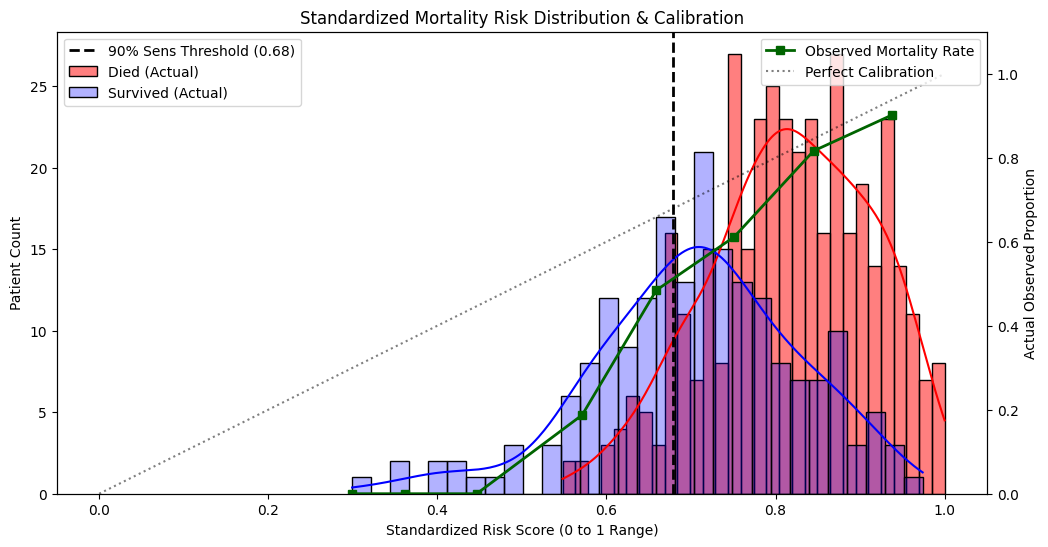

Optimized Standardized Threshold: 0.6784
Calibration Slope (Ideal=1.0): 1.5968
Calibration Intercept (Ideal=0.0): -0.5971
Confusion Matrix:
[[ 77 120]
 [ 34 360]]


IndexError: index -1 is out of bounds for axis 0 with size 0

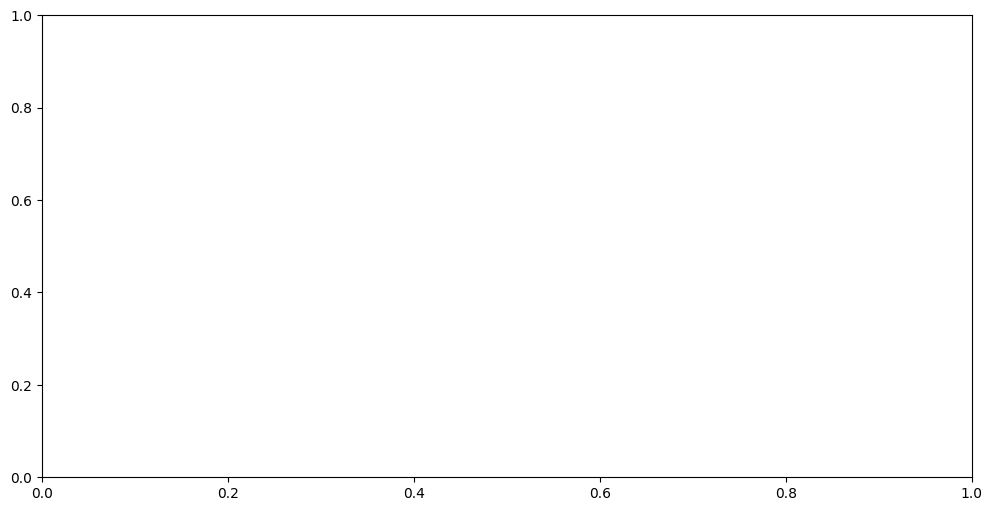

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.calibration import calibration_curve

import random
random.seed(240)
np.random.seed(240)
tf.random.set_seed(240)

class SequentialSurvivalLSTM:
    def __init__(self, sequence_length=12):
        self.sequence_length = sequence_length
        self.feature_cols = [
            'ECOGGRN', 'current_age', 'BMI', 'trxlength', 'VISITNUM',
            'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()
        self.min_max_scaler = MinMaxScaler(feature_range=(0, 1))

    def prepare_data(self, df):
        pid_col = 'RPT' if 'RPT' in df.columns else 'SUBJID'
        X_list, y_status, metadata = [], [], []

        df_scaled = df.copy()
        df_scaled[self.feature_cols] = df_scaled[self.feature_cols].fillna(0)
        df_scaled[self.feature_cols] = self.scaler.fit_transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')

            vdays = p_data['VISDAY'].values[-self.sequence_length:]
            dsday = p_data['DSDAY'].iloc[0] if 'DSDAY' in p_data.columns else np.nan

            feat_seq = p_data[self.feature_cols].values[-self.sequence_length:]

            if len(feat_seq) < self.sequence_length:
                pad_width = self.sequence_length - len(feat_seq)
                feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant')
                vdays = np.pad(vdays.astype(float), (pad_width, 0), mode='constant', constant_values=np.nan)

            X_list.append(feat_seq)
            y_status.append(int(p_data['os_event'].any()))
            metadata.append({'pid': pid, 'vdays': vdays, 'dsday': dsday})

        return np.array(X_list), np.array(y_status), metadata

    def build_sequential_model(self):
        inputs = layers.Input(shape=(self.sequence_length, self.input_dim))
        x = layers.LSTM(64, return_sequences=True, dropout=0.3)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LSTM(32, return_sequences=True, dropout=0.2)(x)
        outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)

        model = models.Model(inputs, outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy')
        return model

    def run_analysis(self, df):
        X, y_true, metadata = self.prepare_data(df)

        model = self.build_sequential_model()
        y_seq = np.repeat(y_true[:, np.newaxis, np.newaxis], self.sequence_length, axis=1)

        model.fit(X, y_seq, epochs=30, batch_size=16, verbose=0)

        raw_visit_risks = model.predict(X)

        flattened_risks = raw_visit_risks.reshape(-1, 1)
        standardized_risks = self.min_max_scaler.fit_transform(flattened_risks)
        all_visit_risks = standardized_risks.reshape(raw_visit_risks.shape)

        max_risks = np.max(all_visit_risks, axis=1).flatten()

        thresholds = np.linspace(0, 1, 200)
        best_t = 0.5
        for t in thresholds:
            preds = (max_risks >= t).astype(int)
            if recall_score(y_true, preds) >= 0.90:
                best_t = t
            else:
                break

        self.plot_combined_analysis(max_risks, y_true, best_t)
        self.plot_lead_time_histogram(all_visit_risks, y_true, metadata, best_t)

    def plot_combined_analysis(self, max_risks, y_true, threshold):
        fig, ax1 = plt.subplots(figsize=(12, 6))

        sns.histplot(max_risks[y_true == 1], color='red', label='Died (Actual)',
                     kde=True, bins=30, alpha=0.5, ax=ax1)
        sns.histplot(max_risks[y_true == 0], color='blue', label='Survived (Actual)',
                     kde=True, bins=30, alpha=0.3, ax=ax1)

        ax1.axvline(threshold, color='black', linestyle='--', linewidth=2,
                    label=f'90% Sens Threshold ({threshold:.2f})')
        ax1.set_xlabel('Standardized Risk Score (0 to 1 Range)')
        ax1.set_ylabel('Patient Count')
        ax1.set_title('Standardized Mortality Risk Distribution & Calibration')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()
        prob_true, prob_pred = calibration_curve(y_true, max_risks, n_bins=10)
        ax2.plot(prob_pred, prob_true, "s-", color='darkgreen', linewidth=2, label='Observed Mortality Rate')
        ax2.plot([0, 1], [0, 1], "k:", alpha=0.5, label='Perfect Calibration')
        ax2.set_ylabel('Actual Observed Proportion')
        ax2.set_ylim(0, 1.1)
        ax2.legend(loc='upper right')
        plt.show()

        # Calculation for Line of Best Fit (Calibration Slope/Intercept)
        slope, intercept = np.polyfit(prob_pred, prob_true, 1)

        # Metrics Summary
        flagged = (max_risks >= threshold).astype(int)
        print(f"Optimized Standardized Threshold: {threshold:.4f}")
        print(f"Calibration Slope (Ideal=1.0): {slope:.4f}")
        print(f"Calibration Intercept (Ideal=0.0): {intercept:.4f}")
        print(f"Confusion Matrix:\n{confusion_matrix(y_true, flagged)}")

    def plot_lead_time_histogram(self, all_visit_risks, y_true, metadata, threshold):
        lead_times = []

        for i in range(len(y_true)):
            if y_true[i] == 1 and np.max(all_visit_risks[i]) >= threshold:
                patient_risks = all_visit_risks[i].flatten()
                flag_indices = np.where(patient_risks >= threshold)[0]

                if len(flag_indices) > 0:
                    first_flag_idx = flag_indices[0]
                    first_flag_day = metadata[i]['vdays'][first_flag_idx]
                    death_day = metadata[i]['dsday']

                    if not np.isnan(first_flag_day) and not np.isnan(death_day):
                        days_before = death_day - first_flag_day
                        lead_times.append(days_before)

        plt.figure(figsize=(12, 6))
        sns.histplot(lead_times, bins=20, kde=True, color='skyblue', edgecolor='black')

        median_val = np.median(lead_times)
        q1 = np.percentile(lead_times, 25)
        q3 = np.percentile(lead_times, 75)
        iqr = q3 - q1

        plt.title(f'Lead Time: Days from First High-Risk Flag to Death (n={len(lead_times)})', fontsize=14)
        plt.xlabel('Days Before Death', fontsize=12)
        plt.ylabel('Number of Patients', fontsize=12)

        plt.axvline(median_val, color='darkblue', linestyle='--', linewidth=2,
                    label=f'Median Lead Time: {median_val:.1f} days')

        plt.legend()
        plt.grid(axis='y', alpha=0.2)
        sns.despine()
        plt.tight_layout()
        plt.show()

        print(f"Analysis for Correctly Flagged High-Risk Patients (n={len(lead_times)}):")
        print(f"Median Lead Time: {median_val:.2f} days")
        print(f"Mean Lead Time: {np.mean(lead_times):.2f} days")
        print(f"IQR (Interquartile Range): {iqr:.2f} days ({q1:.2f} - {q3:.2f})")

# Execution
pcdata = pd.read_csv('pcvaldata.csv')
pipeline = SequentialSurvivalLSTM()
pipeline.run_analysis(pcdata)